## Final Project Submission

Please fill out:
* Student name: Sung Hoon Bae
* Student pace: Full Time
* Scheduled project review date/time: 
* Instructor name: James Irving
* Blog post URL:


# Functions

In [1]:
import pickle
def save_data(data, name):
    with open(name, 'wb') as f:
        pickle.dump(data, f)

def load_data(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [2]:
def get_percent_retained(df):
    original_length = 59400
    print(f'Original Length: {original_length}')
    print(f'Current Length: {df.shape[0]}')
    print(f'Percent Retained: {round(df.shape[0]/original_length * 100, 2)}%')

In [3]:
def drop_rows_na(df, col):
    indices = df[col].dropna().index
    return df.loc[indices,:]

In [168]:
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
def evaluate_clf_model(model,X_train, y_train, X_test,y_test, features=None, 
                       classes=['functioning', 'needs repair', 'nonfunctioning'], 
                       prob=True, normalize='true',cmap='Purples', label='', cv=0):
    """Accepts an sklearn-compatible classification model + test data 
    and displays several sklearn.metrics functions: 
    - classifciation_report
    - plot_confusion_matrix
    - plot_roc_curve
    """
     
    ## Get Predictions
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)
    
    if prob:
        y_proba_train = model.predict_proba(X_train)
        auc_train = metrics.roc_auc_score(y_train, y_proba_train, average='weighted', multi_class='ovr')
        y_proba_test = model.predict_proba(X_test)
        auc_test = metrics.roc_auc_score(y_test, y_proba_test, average='weighted', multi_class='ovr')
    
    if cv!=0:
        cv_score = cross_val_score(model, pd.concat([X_train, X_test]), 
                                   np.concatenate((y_train, y_test), axis=None), 
                                   cv=cv)
    ## Classification Report / Scores 
    table_header = "[i] CLASSIFICATION REPORT"
    
    ## Add Label if given
    if len(label)>0:
        table_header += f" {label}"
    ## PRINT CLASSIFICATION REPORT
    dashes = '---'*20
    print(dashes,table_header,dashes,sep='\n')    
    print('Train Accuracy : ', round(metrics.accuracy_score(y_train, y_hat_train),4))
    print('Test Accuracy : ', round(metrics.accuracy_score(y_test, y_hat_test),4))
    if prob:
        print('Train AUC : ', round(auc_train,4))
        print('Test AUC : ', round(auc_test,4))
    if cv:
        print(f'CV score (n={cv})', round(np.mean(cv_score), 4))
    print(dashes+'\n')
    
    

    print(metrics.classification_report(y_test,y_hat_test,
                                    target_names=classes))
    
    report = metrics.classification_report(y_test,y_hat_test,
                                               target_names=classes,
                                          output_dict=True)
    print(dashes+"\n\n")
    
    

    ## MAKE FIGURE
    fig, ax = plt.subplots(figsize=(10,4))
    ax.grid(False)
    
    ## Plot Confusion Matrix 
    metrics.plot_confusion_matrix(model, X_test,y_test,
                                  display_labels=classes,
                                  normalize=normalize,
                                  cmap=cmap,ax=ax)
    ax.set(title='Confusion Matrix')
    plt.xticks(rotation=45)
    
    if label != 'KNN':
        # Feature Importance
        fig, ax = plt.subplots(figsize=(10,4))

        # get features if not given
        if features==None:
            features = X_train.keys()

        feat_imp = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)[:10]
        feat_imp.plot(kind='barh', title='Feature Importances')
        ax.set(ylabel='Feature Importance Score')
        ax.invert_yaxis() # this will make the graphs in order

    plt.show()
    
    return report, fig, ax

# EDA

In [9]:
# Import necessary libraries needed to EDA.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning) 

In [10]:
# Importing Dataset
def import_data():
    X = pd.read_csv('datasets/Tanzanian/training_set.csv')
    y = pd.read_csv('datasets/Tanzanian/train_result.csv')
    
    y.drop(columns='id', axis=1, inplace=True)
    df = pd.concat([X, y], axis=1)
    return df
df = import_data()
# Converts functional wells into 1 and non-functional ones into 0.
# y['status_group'] = y['status_group'].apply(lambda x: 1 if x=='functional' else 0)

# Import the data and make sure it has loaded well

## Data Cleanup


<AxesSubplot:>

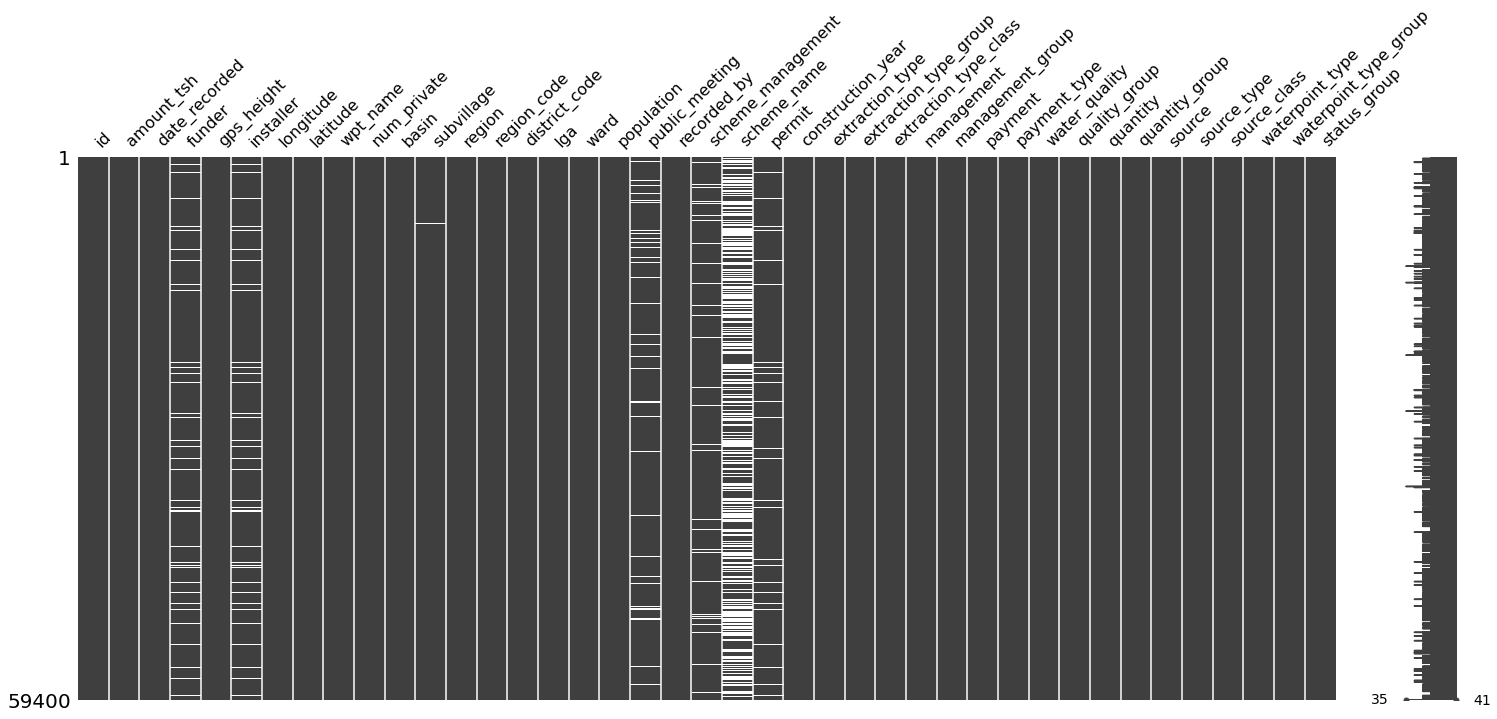

In [11]:
# Checking out if there are any notable patterns in missing value
import missingno as ms
ms.matrix(df)

- We can see that installer and funder columns have similar missing rows.
- We see that scheme_name column is something we should just delete

### Columns to drop

In [12]:
# After exploring each column see 'Explatory Note.ipynb' for detail, the following columns will be deleted.
cols_to_drop = ['id',
 'amount_tsh',
 'num_private',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'recorded_by',
 'extraction_type_group',
 'extraction_type_class',
 'payment',
 'water_quality',
 'source_type',
 'quantity_group',
 'waterpoint_type',
 'scheme_name']

In [13]:
df.drop(columns=cols_to_drop, inplace=True)

### Takes care of datetime

In [14]:
# converts date_recorded into datetime format
df['date_recorded'] = pd.to_datetime(df['date_recorded'])
df['year_recorded'] = df['date_recorded'].apply(lambda x: x.year)
df['month_recorded'] = df['date_recorded'].apply(lambda x: x.month)
df.drop(columns=['date_recorded'], axis=1, inplace=True)

In [15]:
df.head()

,funder,gps_height,installer,longitude,latitude,wpt_name,region_code,district_code,population,public_meeting,...,management_group,payment_type,quality_group,quantity,source,source_class,waterpoint_type_group,status_group,year_recorded,month_recorded
0,Roman,1390,Roman,34.938093,-9.856322,none,11,5,109,True,...,user-group,annually,good,enough,spring,groundwater,communal standpipe,functional,2011,3
1,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,20,2,280,NaN,...,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional,2013,3
2,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,21,4,250,True,...,user-group,per bucket,good,enough,dam,surface,communal standpipe,functional,2013,2
3,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,90,63,58,True,...,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe,non functional,2013,1
4,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,18,1,0,True,...,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,functional,2011,7


### wpt_name into a boolean column

In [16]:
# 1 if a name exists and 0 if not.
df['wpt_name'] = (df['wpt_name']!='none').astype(int)

In [17]:
df.isna().sum()

funder                   3635
gps_height                  0
installer                3655
longitude                   0
latitude                    0
wpt_name                    0
region_code                 0
district_code               0
population                  0
public_meeting           3334
scheme_management        3877
permit                   3056
construction_year           0
extraction_type             0
management                  0
management_group            0
payment_type                0
quality_group               0
quantity                    0
source                      0
source_class                0
waterpoint_type_group       0
status_group                0
year_recorded               0
month_recorded              0
dtype: int64

## Dropping missing rows

In [18]:
df = drop_rows_na(df, 'public_meeting')
df = drop_rows_na(df, 'permit')

<AxesSubplot:>

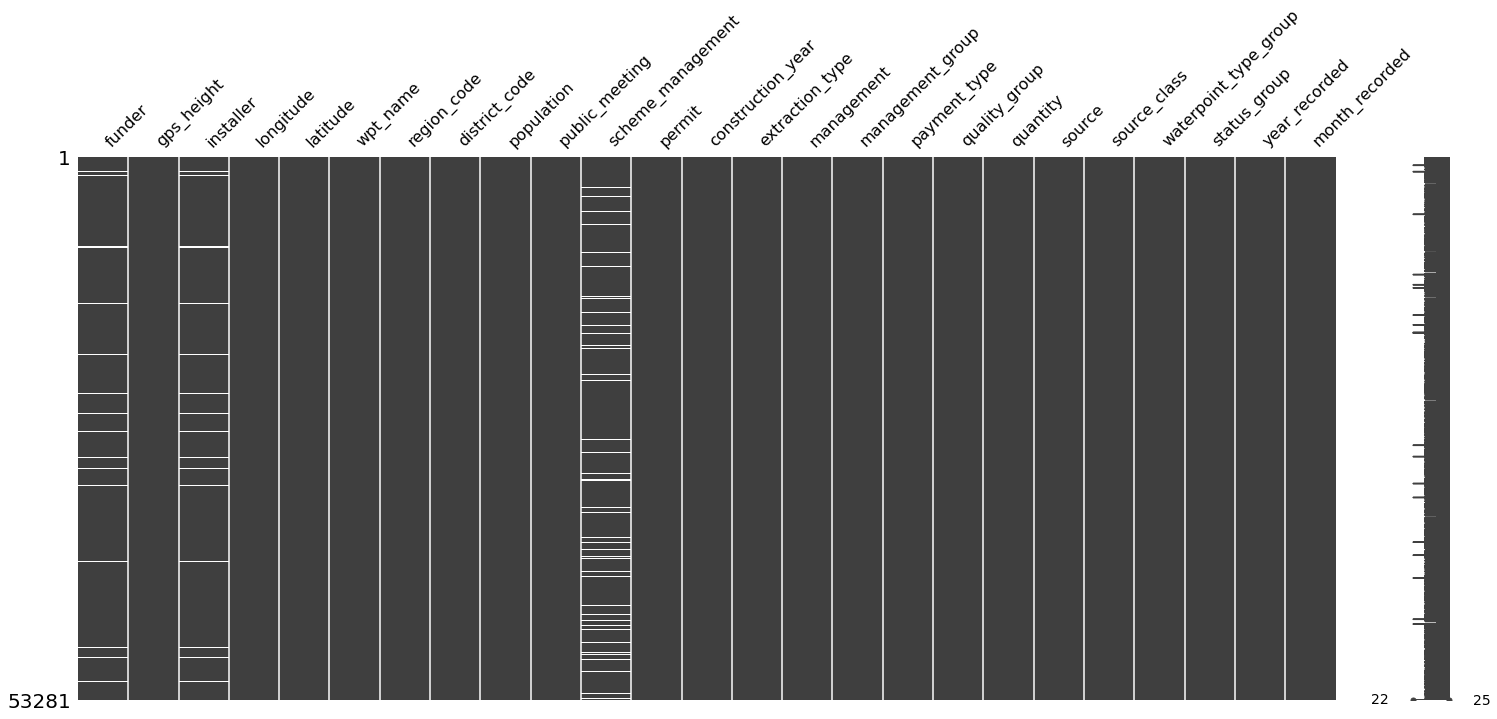

In [19]:
# missing values
ms.matrix(df)

In [20]:
get_percent_retained(df)

Original Length: 59400
Current Length: 53281
Percent Retained: 89.7%


## Cat vs Num columns

In [21]:
# Categorical Columns
cat_cols = df.drop(columns='status_group', axis=1).select_dtypes('O').columns
# Numerical Columsn
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

In [22]:
cat_cols = list(cat_cols)
num_cols = list(num_cols)

In [23]:
num_cols

['gps_height',
 'longitude',
 'latitude',
 'wpt_name',
 'region_code',
 'district_code',
 'population',
 'construction_year',
 'year_recorded',
 'month_recorded']

## Correlation between numerical columns

<AxesSubplot:>

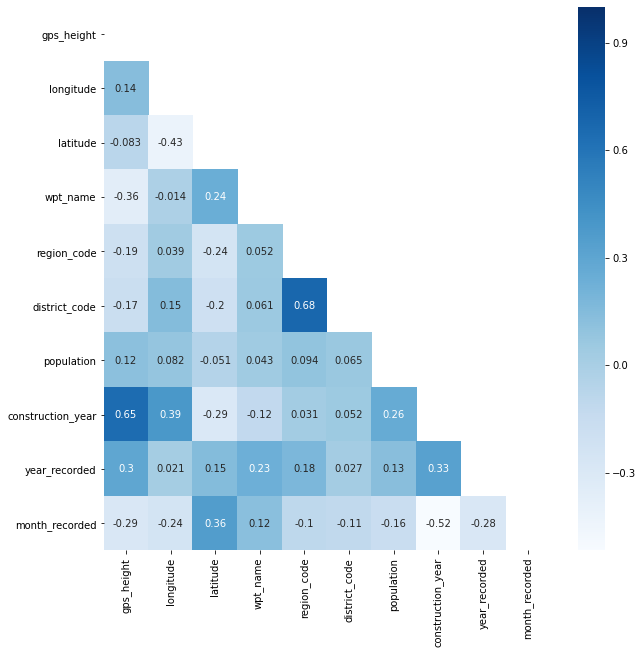

In [24]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), cmap='Blues', mask=mask, annot=True)

> Observation:
    - High correlation between region code and district code which makes sense.
    - High correlation between construction year and height. Perhaps this means that as the time went by people were able to make wells in higher altitudes.

# Vanilla Models

## Splitting Data

In [25]:
from sklearn.metrics import accuracy_score, auc, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split

In [26]:
X = df.drop(columns=['status_group'], axis=1)
y = df['status_group']

In [27]:
# Transforms y into 0, 1, 2
from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(y)

# 0 = func, 1 = repair, 2 = non_func wells
pd.Series(y).value_counts(1)

0    0.545504
2    0.381919
1    0.072577
dtype: float64

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.4, random_state=42)

## Setting pipeline

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import set_config
set_config(display='diagram')

In [30]:
# Creates pipeline for dealing with num and cat columns
pipe_cat = Pipeline(steps=[('imp', SimpleImputer(strategy='constant', fill_value='MISSING')),
                           ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

pipe_num = Pipeline(steps=[('imp', SimpleImputer(missing_values=0, strategy='median')),
                           ('scale', StandardScaler())])

In [31]:
# Combines the two pipelines above into one
preprocessing = ColumnTransformer(transformers=[
    ('cat', pipe_cat, cat_cols),
    ('num', pipe_num, num_cols)
])
preprocessing

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imp',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['funder', 'installer', 'public_meeting',
                                  'scheme_management', 'permit',
                                  'extraction_type', 'management',
                                  'management_group', 'payment_type',
                                  'quality_group', 'quantity', 'source',
                                  'source_class', 'waterpoint_type_group']),
                                ('num',
                                 Pipeline(steps=[('imp',
                                                  SimpleImputer(missing_values=0,
                                                                strategy='median')),
                                                 ('scale', StandardScaler())]),
                                 ['gps_height', 'longitude', 'latitude',
                                  'wpt_name', 'region_code', 'district_code',
                                  'population', 'construction_year',
                                  'year_recorded', 'month_recorded'])])

In [32]:
X_train_tf = preprocessing.fit_transform(X_train)
X_test_tf = preprocessing.transform(X_test)

In [33]:
feature_names = preprocessing.named_transformers_['cat'].\
                named_steps['encoder'].get_feature_names(cat_cols).tolist()
feature_names

features = feature_names+num_cols

In [34]:
X_train_tf = pd.DataFrame(X_train_tf, columns = features)
X_test_tf = pd.DataFrame(X_test_tf, columns = features)

## Round 1 models

In [35]:
# imports all the libraries needed to model
import sklearn.svm as svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

### Random Tree Model

In [37]:
rf = RandomForestClassifier()
rf.fit(X_train_tf, y_train)

RandomForestClassifier()

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
Train Accuracy :  0.9981
Test Accuracy :  0.7885
Train AUC :  0.9999
Test AUC :  0.8867
------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.80      0.87      0.83     17455
           1       0.46      0.30      0.36      2315
           2       0.82      0.76      0.79     12199

    accuracy                           0.79     31969
   macro avg       0.69      0.64      0.66     31969
weighted avg       0.78      0.79      0.78     31969

------------------------------------------------------------




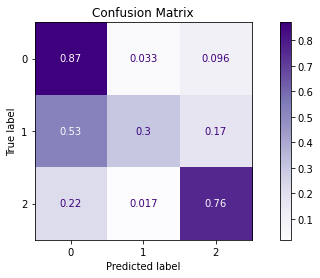

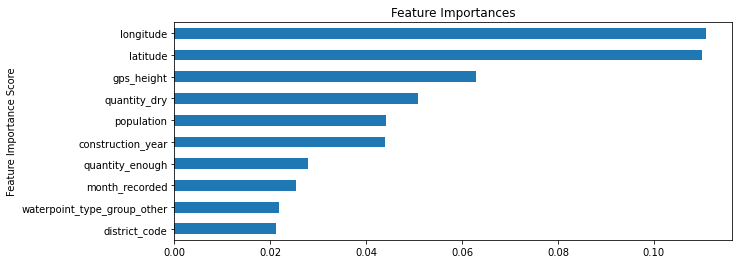

In [38]:
evaluate_clf_model(rf, X_train_tf, y_train, X_test_tf, y_test);

### Decision Tree

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
Train Accuracy :  0.9982
Test Accuracy :  0.7408
Train AUC :  1.0
Test AUC :  0.7695
------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.79      0.79      0.79     17455
           1       0.34      0.33      0.33      2315
           2       0.75      0.74      0.75     12199

    accuracy                           0.74     31969
   macro avg       0.62      0.62      0.62     31969
weighted avg       0.74      0.74      0.74     31969

------------------------------------------------------------




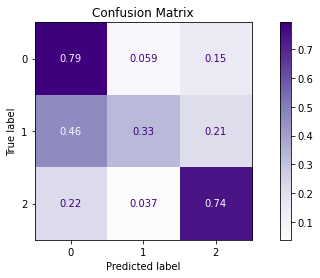

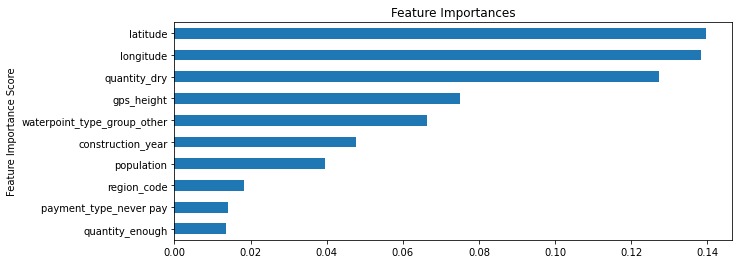

In [39]:
tree = DecisionTreeClassifier()
tree.fit(X_train_tf, y_train)

evaluate_clf_model(tree, X_train_tf, y_train, X_test_tf, y_test);

### XGBoost classifier

In [ ]:
temp_col_names = [f'x{i}' for i in range(len(X_train_tf.columns))]
X_train_tf.columns = temp_col_names
X_train_tf.head()

In [41]:
xgb = XGBClassifier()
xgb.fit(X_train_tf, y_train)

KeyboardInterrupt: 

In [ ]:
X_test_tf.columns = temp_col_names
evaluate_clf_model(xgb, X_train_tf, y_train, X_test_tf, y_test);

In [ ]:
X_train_tf.columns = features
X_test_tf.columns = features

### Adaboost classifier

In [ ]:
ab = AdaBoostClassifier()
ab.fit(X_train_tf, y_train)

evaluate_clf_model(ab, X_train_tf, y_train, X_test_tf, y_test);

### KNN Classifier

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train_tf, y_train)

evaluate_clf_model(knn, X_train_tf, y_train, X_test_tf, y_test);

### SVM Classifier

In [ ]:
sv = svm.SVC(kernel='linear', class_weight=class_weight_dict, probability=True)
sv.fit(X_train_tf, y_train)

In [ ]:
evaluate_clf_model(sv, X_train_tf, y_train, X_test_tf, y_test);

## Conclusion: Round 1 models

- Need to deal with class imbalance
    - Method 1: Use SMOTE or SMOTENC to oversample
    - Method 2: Undersample
    - Method 3: Use class_weight parameter to give penalties to the class with higher number of samples

- We will try method 1 and method 3 for the next round

- We will need to feature engineer new features!
  

# Models Round 2

In [637]:
cols_to_drop=['amount_tsh',
 'num_private',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'recorded_by',
 'extraction_type_group',
 'extraction_type_class',
 'water_quality',
 'source_type',
 'quantity_group',
 'waterpoint_type',
 'scheme_name',
 'id']

## Dropping Different Additional Columns

In [642]:
def import_data(drop_cols=None):
    X = pd.read_csv('datasets/Tanzanian/training_set.csv')
    y = pd.read_csv('datasets/Tanzanian/train_result.csv')
    
    X['date_recorded'] = pd.to_datetime(X['date_recorded'])
    X['year_recorded'] = X['date_recorded'].apply(lambda x: x.year)
    X['month_recorded'] = X['date_recorded'].apply(lambda x: x.month)
    X.drop(columns=['date_recorded'], axis=1, inplace=True)
    
    # Changes 0 to recorded year for construction year
    mask = X['construction_year'] == 0
    X['construction_year'][mask] = X['year_recorded'][mask]
    
    # 1 if a name exists and 0 if not.
    X['wpt_name'] = X['wpt_name']!='none'
    
    if drop_cols != None:
        X.drop(columns=drop_cols, axis=1, inplace=True)
    
    df = pd.concat([X, y[['status_group']]], axis=1)
    
    cols = ['permit', 'public_meeting']
    for col in cols:
        df = drop_rows_na(df, col)
        df = df.reset_index().drop(columns='index')
    
    # get rid of rows with 0 lat and 0 long
    df.drop(df[(df['latitude']>-0.5)].index, inplace=True)
    df = df.reset_index().drop(columns='index')
    
    get_percent_retained(df)
    return df

In [643]:
# Import Data
df = import_data(cols_to_drop)

X = df.drop(columns='status_group', axis=1)
y = df[['status_group']]

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Original Length: 59400
Current Length: 51827
Percent Retained: 87.25%


## Feature #1: percent nearby within 30km radius

As for first of new feature, we will add 

    [1] percent of functioning wells near 30 km radius
    [2] percent of non-functioning wells near 30 km radius and 
    [3] percent of functioning but needs repair wells near 30 km radius.


In [644]:
import math
def get_distance(x, y):
    """
    x = [lat and long]
    y = array of lat and long
    """
    pi = np.pi
    R = 6371 # Average Earth radius in km
    
    # converts to radians
    lat1 = x[0]*pi/180 
    lat2 = y.iloc[:,0]*pi/180
    long1 = x[1]*pi/180
    long2 = y.iloc[:,1]*pi/180

    # finds delta angles
    del_lat = lat1 - lat2
    del_long = long1 - long2
        
    # Source: https://www.movable-type.co.uk/
    a = np.sin(del_lat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(del_long/2)**2
    c = 2*np.arctan(np.sqrt(a)/np.sqrt(1-a))
    d= R*c # distance in km
        
    return d

In [645]:
print(X.shape, y.shape)

(51827, 25) (51827, 1)


In [646]:
# Calculates percentage of functional, nonfunctional, and need repair wells within certain radius (30 km)
perc_func_near = []
perc_non_func_near = []
perc_repair_near = []

for index, row in X.iterrows():
#     print(index, row['latitude'], row['longitude'])
    wp = [row['latitude'], row['longitude']]
    wps = X[['latitude', 'longitude']].copy()
    
    d = get_distance(wp, wps)
    
    distance = 30
    indices = X[d < distance].index
    

    perc_func = round(np.sum(y.iloc[indices, :] == 'functional')/len(indices)*100, 2)
    perc_non_func = round(np.sum(y.iloc[indices, :] == 'non functional')/len(indices)*100, 2)
    perc_repair_func = round(np.sum(y.iloc[indices, :] == 'functional needs repair')/len(indices)*100, 2)
    
    perc_func_near.append(perc_func[0])
    perc_non_func_near.append(perc_non_func[0])
    perc_repair_near.append(perc_repair_func[0])
    



# Assigns percentages in appropriate columns
df['perc_func_nearby'] = perc_func_near
df['perc_non_func_nearby'] = perc_non_func_near
df['perc_repair_nearby'] = perc_repair_near

KeyboardInterrupt: 

## Feature #2 Extraction Type

Based on our observations, it seemed like many of extraction types could be simplified into 'other' group. So minority types (anything that has <1%) will be counted as 'other' extraction type.

In [649]:
df['extraction_type'].value_counts(normalize=True)

gravity          0.468057
other            0.186563
nira             0.128485
submersible      0.075173
mono             0.047697
india mark ii    0.041928
afridev          0.027457
ksb              0.024640
Name: extraction_type, dtype: float64

In [ ]:
df['extraction_type'].unique()

In [ ]:
# Extraction dictionary to simplify some of trivial ones as 'other'
extraction_dict = {'nira/tanira':'nira', 'swn 80':'other', 
                   'other - rope pump': 'other', 'other - swn 81': 'other',
                   'other - play pump': 'other', 'other - mkulima/shinyanga':'other',
                   'windmill': 'other', 'cemo':'other', 'climax':'other',
                   'walimi':'other', 'india mark iii':'other'}

# replaces insignificant extractor types as 'other'
df['extraction_type'] = df['extraction_type'].apply(lambda x: extraction_dict[x] if x in extraction_dict.keys() else x)

## Feature #3: installer and funder

There are way too many unique values for installer and funder. We could try to do two different approach for this:

    [1] Label encode - giving each category a value making it into a numerical column instead of one-hot-encoding.
    [2] Something different.

We will try to do something different for fun. We will see calculate

    [1] percent functioning wells.
    [2] percent non functioning wells.
    [3] percent needing repair wells.

for each funder and installer.

In [50]:
# makes a dictionary that has percent func/non func/repair for each installer
def get_percent(data = df, col='installer', drop=True):
    if col in data.keys():
        # copies the column
        sample = data[[col, 'status_group']].copy()

        # Get dummies for the column
        sample_dummies = pd.get_dummies(sample, columns=['status_group'])

        # Sum total functioning, nonfunctioning, and needing repair wells for each group
        a = sample_dummies.groupby(col).sum()

        a['total'] = a.sum(axis=1)

        # Get percentages
        a['perc_func'] = a['status_group_functional']/a['total']
        a['perc_repair'] = a['status_group_functional needs repair']/a['total']
        a['perc_non_func'] = a['status_group_non functional']/a['total']

        a = a[['perc_func', 'perc_repair', 'perc_non_func']].reset_index()
        
        perc_dict = {}
        for index, row in a.iterrows():
            perc_dict[row[col]] = [row['perc_func'], row['perc_repair'], row['perc_non_func']]

        data[f'{col}_perc_func'] = data[col].apply(lambda x: perc_dict[x][0] if x in perc_dict.keys() else np.NaN)
        data[f'{col}_perc_repair'] = data[col].apply(lambda x: perc_dict[x][1] if x in perc_dict.keys() else np.NaN)
        data[f'{col}_perc_non_func'] = data[col].apply(lambda x: perc_dict[x][2] if x in perc_dict.keys() else np.NaN)
        
        if drop:
            data.drop(columns=[col], axis=1, inplace=True)
    else:
        print(f'Column name {col} not found.')
    
    return perc_dict

In [51]:
# Gets percetnages for different installers
installer_dict = get_percent(df, col='installer')

# Gets percetnages for different funders
funder_dict = get_percent(df, col='funder')

In [52]:
# # Saves the data for future use
# save_data(installer_dict, 'installer_dict')
# save_data(funder_dict, 'funder_dict')

## Feature Selections

In [647]:
# Saving dataframe until now
# save_data(df, 'final_df')
# loading datafrom for model #2
df = load_data('final_df')

<AxesSubplot:>

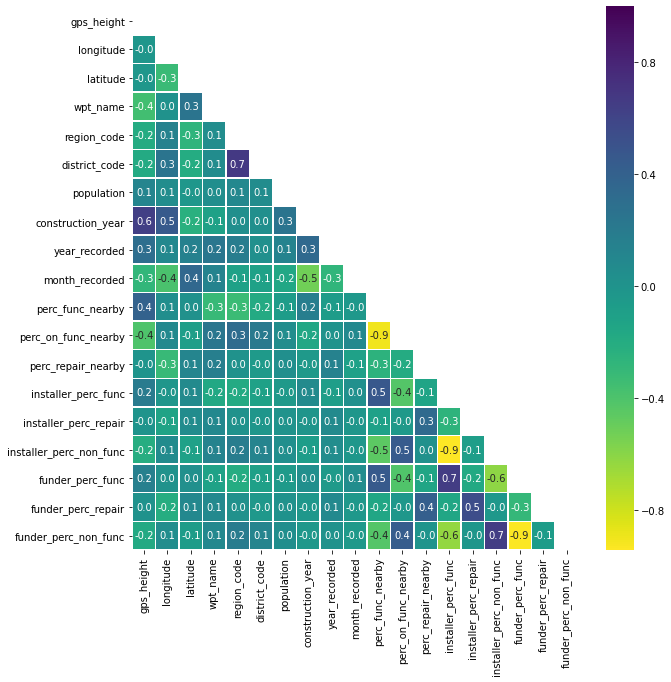

In [59]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), cmap='viridis_r', mask=mask, annot=True, linewidths=0.5, fmt='.1f')

> As you can see above, percent func and percent non_func are highly correlated. We will just use percent functioning for our models.

In [283]:
# Three features that will be eliminated from the data
drop_features = ['funder_perc_non_func', 'installer_perc_non_func', 'perc_on_func_nearby']
df_1 = df.drop(columns=drop_features, axis=1).copy()

<AxesSubplot:>

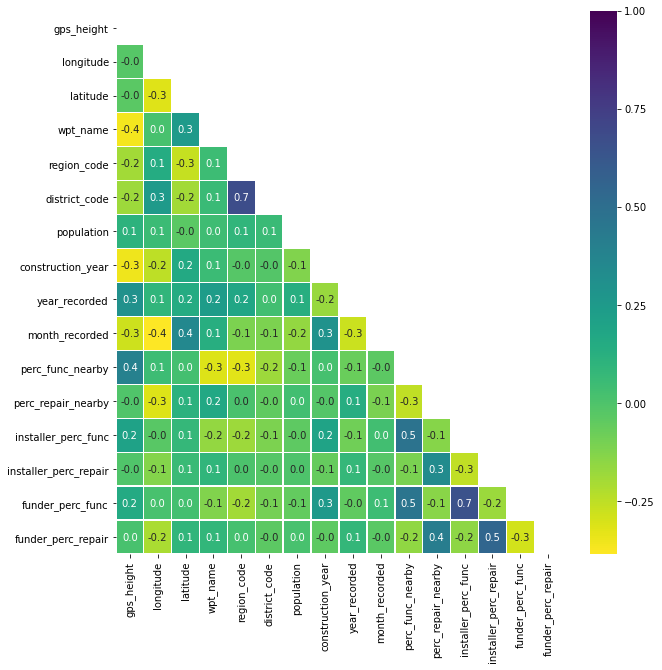

In [284]:
mask = np.zeros_like(df_1.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_1.corr(), cmap='viridis_r', mask=mask, annot=True, linewidths=0.5, fmt='.1f')

Now, we will check whether we have seleceted the right features.

## Splitting

In [292]:
# Redefine cat and num columns
cat_cols = list(df_1.drop(columns='status_group', axis=1).select_dtypes('O').columns)
cat_cols.append('wpt_name')
num_cols = list(df_1.select_dtypes(['int64', 'float64']).columns)

In [293]:
from sklearn.model_selection import train_test_split
# df.drop(columns='scheme_management', axis=1, inplace=True)
X = df_1.drop(columns='status_group', axis=1)
y = df_1['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

## Preprocessing

In [294]:
# encodes y into 0, 1, 2
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train_tf = encoder.fit_transform(y_train)
y_test_tf = encoder.transform(y_test)

In [295]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import set_config
set_config(display='diagram')

In [296]:
from sklearn.pipeline import Pipeline
pipe_cat = Pipeline(steps=[('imp', SimpleImputer(strategy='constant', fill_value='MISSING')),
                           ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

pipe_num = Pipeline(steps=[('imp', SimpleImputer(strategy='median')),
                           ('scale', StandardScaler())])

In [297]:
preprocessing2 = ColumnTransformer(transformers=[('num', pipe_num, num_cols),
                                                 ('cat', pipe_cat, cat_cols)])
preprocessing2

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imp',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', StandardScaler())]),
                                 ['gps_height', 'longitude', 'latitude',
                                  'region_code', 'district_code', 'population',
                                  'construction_year', 'year_recorded',
                                  'month_recorded', 'perc_func_nearby',
                                  'perc_repair_nearby', 'installer_perc_func',
                                  'installer_perc_repair', 'funde...
                                 Pipeline(steps=[('imp',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['public_meeting', 'scheme_management',
                                  'permit', 'extraction_type', 'management',
                                  'management_group', 'payment', 'payment_type',
                                  'quality_group', 'quantity', 'source',
                                  'source_class', 'waterpoint_type_group',
                                  'wpt_name'])])

In [298]:
X_train_tf = preprocessing2.fit_transform(X_train)

In [299]:
feature_names = preprocessing2.named_transformers_['cat'].\
                named_steps['encoder'].get_feature_names(cat_cols).tolist()
feature_names

features = num_cols + feature_names

X_train_tf = pd.DataFrame(X_train_tf, columns = features)

In [300]:
X_test_tf = preprocessing2.transform(X_test)
X_test_tf = pd.DataFrame(X_test_tf, columns = features)

## SMOTE

In order to respond to class imbalance, SMOTE will be implemented which over samples under-represented classes by generating data based on known data.

In [301]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

from imblearn.over_sampling import SMOTE

In [302]:
pd.Series(y_train_tf).value_counts(normalize=True)

0    0.550223
2    0.381388
1    0.068389
dtype: float64

In [303]:
# # get the number of columns that are categorical
# cat_cols_nums = [k for k, x in enumerate(df.columns) if x in cat_cols]
# cat_cols_nums

In [304]:
X_train_smote_tf, y_train_smote_tf = SMOTE().fit_resample(X_train_tf, y_train_tf)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [305]:
pd.Series(y_train_smote_tf).value_counts(normalize=True)

2    0.333333
1    0.333333
0    0.333333
dtype: float64

In [306]:
X_train_smote_tf = pd.DataFrame(X_train_smote_tf, columns = X_train_tf.columns)
X_train_smote_tf

,gps_height,longitude,latitude,region_code,district_code,population,construction_year,year_recorded,month_recorded,perc_func_nearby,...,source_class_surface,source_class_unknown,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other,wpt_name_False,wpt_name_True
0,1.435816,-0.256214,-1.376048,-0.230433,-0.088365,-0.151195,-0.782983,-0.900086,-0.436093,1.761198,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.800097,-1.316811,-0.795271,-0.010513,-0.188039,0.711401,-1.434149,1.184856,-1.113344,-0.693659,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.960667,-0.388206,1.085076,0.099447,-0.487060,0.711401,-0.050422,1.184856,-0.774718,0.424658,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.543112,0.752072,0.947126,-0.670274,-0.088365,-0.364043,-0.213213,1.184856,0.579783,1.177255,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.980243,-0.998025,-1.145203,-0.175453,0.011309,-0.408853,0.763535,-0.900086,0.918409,-0.823021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59878,-0.980243,-0.517515,0.931879,0.099447,-0.387386,-0.408853,0.844931,0.142385,1.945429,0.037542,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
59879,0.529147,0.171340,0.765262,0.268646,-0.487060,-0.036944,0.087292,1.184856,-0.514192,1.348016,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
59880,-0.537364,0.501890,-0.944725,-0.560314,-0.188039,0.120108,0.120408,-0.900086,-0.436093,1.029653,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
59881,0.772749,-0.782768,1.411234,0.209407,-0.487060,0.656866,-2.248107,-0.900086,0.918409,-1.698331,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


> Not all models will implement SMOTE.

## Classweight

Another way to deal with class imbalance is to use class_weight. There are two different ways to use class weight.

    [1]. Array form - an array of class weights 
    [2]. Dictionary form - a dictionary with class label along with corresponding class weight values.
    
Class weight values will be calculated using sklearn.utils.class_weight

In [307]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = list(compute_class_weight(class_weight='balanced', classes=[0, 1, 2], y=y_train_tf))
print(class_weight)
class_weight_dict = {0: class_weight[0],
                1: class_weight[1],
                2: class_weight[2]}

[0.6058146719436234, 4.874109901921268, 0.8740001927339308]


## Modeling

We will create vanilla models again with dataset with newly engineered features to see whether these new features have helped the model.

### Models

In [80]:
def create_models(X_train, y_train, rf=True, tree=True, xgb=True, ab=True, knn=True, sv=True):
    models = []
    model_names = []
    if rf:
        rf = RandomForestClassifier()
        rf.fit(X_train, y_train)
        models.append(rf)
        model_names.append('Random Forest')
    
    if tree:
        tree = DecisionTreeClassifier()
        tree.fit(X_train, y_train)
        models.append(tree)
        model_names.append('Decision Tree')
    
    if xgb:
        xgb = XGBClassifier()
        xgb.fit(X_train, y_train)
        models.append(xgb)
        model_names.append('XGBoost')
    
    if ab:
        ab = AdaBoostClassifier()
        ab.fit(X_train, y_train)
        models.append(ab)
        model_names.append('AdaBoost')
    
    if knn:
        knn = KNeighborsClassifier()
        knn.fit(X_train, y_train)
        models.append(knn)
        model_names.append('KNN')
    
    if sv:
        sv = svm.SVC()
        sv.fit(X_train, y_train)
        models.append(sv)
        model_names.append('Support Vector Machine')
    
    
    return models, model_names

In [81]:
models = create_models(X_train_smote_tf, y_train_smote_tf, sv=False)

models_2, model_names_2 = models

### Evaluating Models

------------------------------------------------------------
[i] CLASSIFICATION REPORT Random Forest
------------------------------------------------------------
Train Accuracy :  1.0
Test Accuracy :  0.7972
Train AUC :  1.0
Test AUC :  0.9044
------------------------------------------------------------

              precision    recall  f1-score   support

        func       0.83      0.84      0.84      8490
      repair       0.39      0.46      0.42      1019
    non_func       0.83      0.80      0.81      6040

    accuracy                           0.80     15549
   macro avg       0.68      0.70      0.69     15549
weighted avg       0.80      0.80      0.80     15549

------------------------------------------------------------




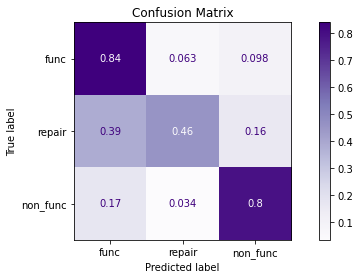

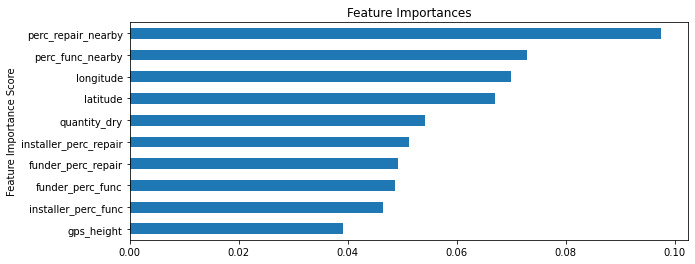

------------------------------------------------------------
[i] CLASSIFICATION REPORT Decision Tree
------------------------------------------------------------
Train Accuracy :  1.0
Test Accuracy :  0.7462
Train AUC :  1.0
Test AUC :  0.7811
------------------------------------------------------------

              precision    recall  f1-score   support

        func       0.81      0.77      0.79      8490
      repair       0.31      0.41      0.36      1019
    non_func       0.76      0.77      0.76      6040

    accuracy                           0.75     15549
   macro avg       0.63      0.65      0.64     15549
weighted avg       0.76      0.75      0.75     15549

------------------------------------------------------------




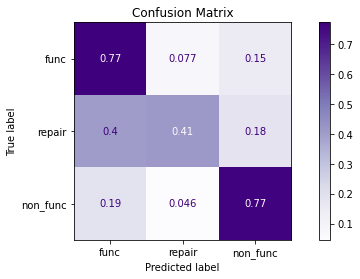

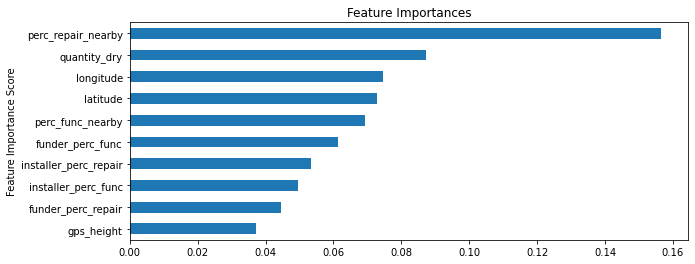

------------------------------------------------------------
[i] CLASSIFICATION REPORT XGBoost
------------------------------------------------------------
Train Accuracy :  0.7451
Test Accuracy :  0.6881
Train AUC :  0.9007
Test AUC :  0.8672
------------------------------------------------------------

              precision    recall  f1-score   support

        func       0.82      0.69      0.75      8490
      repair       0.22      0.72      0.34      1019
    non_func       0.81      0.68      0.74      6040

    accuracy                           0.69     15549
   macro avg       0.62      0.70      0.61     15549
weighted avg       0.78      0.69      0.72     15549

------------------------------------------------------------




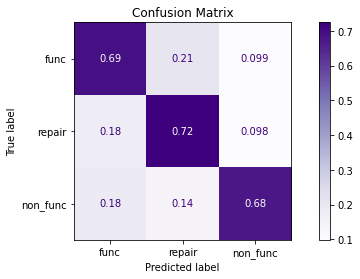

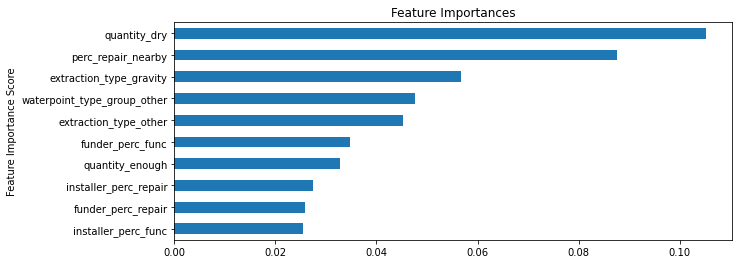

------------------------------------------------------------
[i] CLASSIFICATION REPORT AdaBoost
------------------------------------------------------------
Train Accuracy :  0.7051
Test Accuracy :  0.6683
Train AUC :  0.8289
Test AUC :  0.7279
------------------------------------------------------------

              precision    recall  f1-score   support

        func       0.80      0.68      0.74      8490
      repair       0.21      0.68      0.32      1019
    non_func       0.77      0.65      0.71      6040

    accuracy                           0.67     15549
   macro avg       0.59      0.67      0.59     15549
weighted avg       0.75      0.67      0.70     15549

------------------------------------------------------------




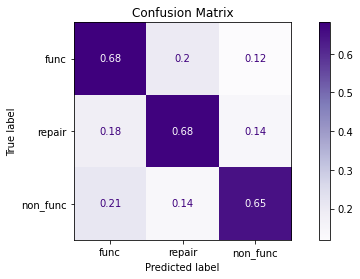

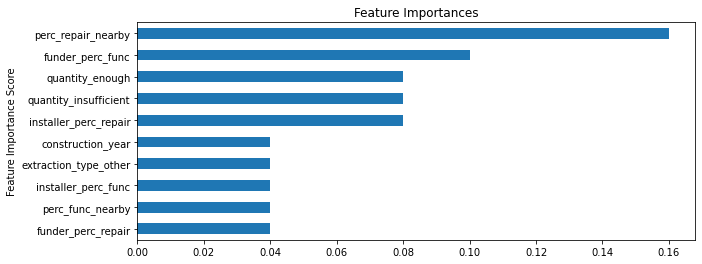

------------------------------------------------------------
[i] CLASSIFICATION REPORT KNN
------------------------------------------------------------
Train Accuracy :  0.8845
Test Accuracy :  0.7337
Train AUC :  0.9809
Test AUC :  0.8579
------------------------------------------------------------

              precision    recall  f1-score   support

        func       0.83      0.75      0.79      8490
      repair       0.27      0.60      0.37      1019
    non_func       0.79      0.74      0.76      6040

    accuracy                           0.73     15549
   macro avg       0.63      0.69      0.64     15549
weighted avg       0.78      0.73      0.75     15549

------------------------------------------------------------




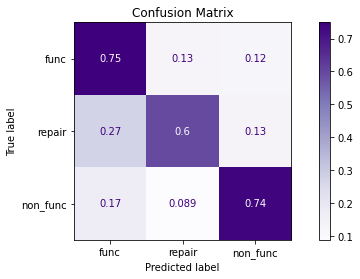

In [83]:
model_reports = []
for model, name in zip(models_2, model_names_2):
    model_report = evaluate_clf_model(model, 
                                      X_train_smote_tf, 
                                      y_train_smote_tf,
                                      X_test_tf, 
                                      y_test_tf,
                                      classes=['func', 'repair', 'non_func'],
                                      label=name);
    model_reports.append(model_report)

> Observations - Round 2

    [1]. Random Forest - Overfit. Needs hyperparameter tuning.
    [2]. Decision Tree - Overfit. Will not be used since we have random forest.
    [3]. XGBoost - Balanced. Will be used in our stack model.
    [4]. Adaboost - Balanced. Will be used in our stack model.
    [5]. KNN - Balanced. Even though it takes a lot of time, we will use this model.
    [6]. SVM - Balanced. It takes a lot of time though.

    - Overall, the models gave higher recall values for repair wells compared to non-smote dataset. However, it gave bias for repair resulting in lowering recalls for other categories.

In [84]:
# Saves the models
save_data(model_reports, 'model_2_report')
save_data(models_2, 'model_2')

# Hyperparamter Tuning

During hyperparameter tuning, we will try to see whether explicitly defining class weight helps with the model.

In [85]:
# save_data([grid_rf_2, grid_xgb, grid_xgb_smote, grid_ab, grid_sv, grid_et, grid_gb], 'final_models')
RF, LR, XGB, AB, ET, GB, KNN = load_data('final_models')

## Random Forest hyperparameter tuning

In [308]:
from sklearn.model_selection import GridSearchCV
RF = RandomForestClassifier(criterion='gini',
                            n_estimators=1000,
                            class_weight=class_weight_dict,
                            max_depth = 15,
                            min_samples_split=0.001,
                            max_features='sqrt')
RF.fit(X_train_tf, y_train_tf)

RandomForestClassifier(class_weight={0: 0.6058146719436234,
                                     1: 4.874109901921268,
                                     2: 0.8740001927339308},
                       max_depth=15, max_features='sqrt',
                       min_samples_split=0.001, n_estimators=1000)

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
Train Accuracy :  0.7773
Test Accuracy :  0.7401
Train AUC :  0.922
Test AUC :  0.8927
------------------------------------------------------------

                precision    recall  f1-score   support

   functioning       0.85      0.74      0.79      8490
  needs repair       0.27      0.73      0.40      1019
nonfunctioning       0.83      0.75      0.79      6040

      accuracy                           0.74     15549
     macro avg       0.65      0.74      0.66     15549
  weighted avg       0.80      0.74      0.76     15549

------------------------------------------------------------




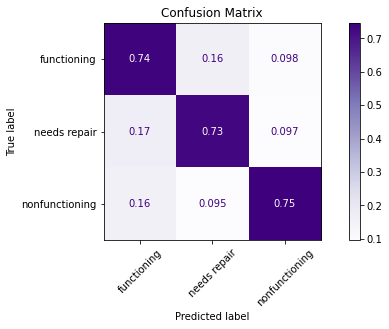

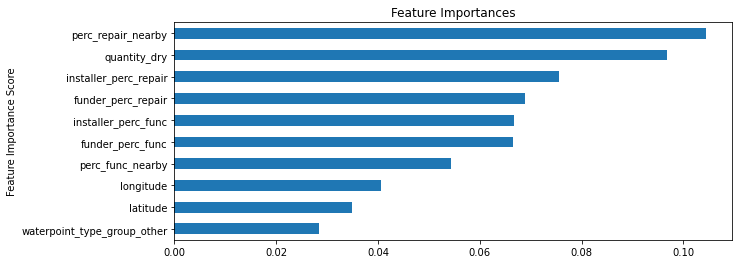

In [309]:
evaluate_clf_model(RF, X_train_tf, y_train_tf, X_test_tf, y_test_tf);

> Random Forest Evaluation
    - Close train and test sets show us that the model is not over fit.
    - Relatively high AUC for both train and test datasets.
    - various percerntages of functionalities of wells affected the model the most.
    - Relatively balanced recalls for all three categories
   

## Linear Regressor

In [310]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(random_state = 0, 
                        max_iter = 1000)
LR.fit(X_train_tf, y_train_tf)

LogisticRegression(max_iter=1000, random_state=0)

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
Train Accuracy :  0.7625
Test Accuracy :  0.7688
Train AUC :  0.8677
Test AUC :  0.8702
------------------------------------------------------------

                precision    recall  f1-score   support

   functioning       0.76      0.89      0.82      8490
  needs repair       0.48      0.18      0.27      1019
nonfunctioning       0.81      0.70      0.75      6040

      accuracy                           0.77     15549
     macro avg       0.68      0.59      0.61     15549
  weighted avg       0.76      0.77      0.76     15549

------------------------------------------------------------




AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

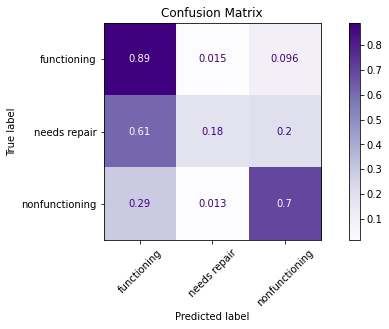

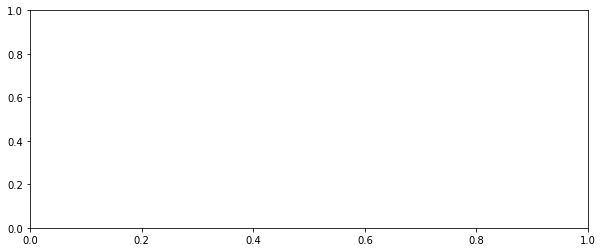

In [311]:
evaluate_clf_model(LR, X_train_tf, y_train_tf, X_test_tf, y_test_tf);

## XGBoost Hyperparameter Tuning

In [314]:
# from sklearn.model_selection import GridSearchCV
XGB = XGBClassifier(objective='mutli:softmax', num_class=3, 
                    class_weight=class_weight_dict,
                    n_estimators=200,
                    max_depth=5,
                    subsample=0.6,
                    min_child_weight=0.8)

XGB.fit(X_train_tf, y_train_tf)

XGBClassifier(class_weight={0: 0.6058146719436234, 1: 4.874109901921268,
                            2: 0.8740001927339308},
              max_depth=5, min_child_weight=0.8, n_estimators=200, num_class=3,
              objective='multi:softprob', subsample=0.6)

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
Train Accuracy :  0.8219
Test Accuracy :  0.8023
Train AUC :  0.9296
Test AUC :  0.9081
------------------------------------------------------------

                precision    recall  f1-score   support

   functioning       0.78      0.92      0.85      8490
  needs repair       0.62      0.22      0.32      1019
nonfunctioning       0.85      0.74      0.79      6040

      accuracy                           0.80     15549
     macro avg       0.75      0.62      0.65     15549
  weighted avg       0.80      0.80      0.79     15549

------------------------------------------------------------




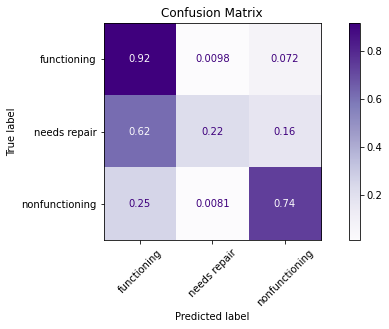

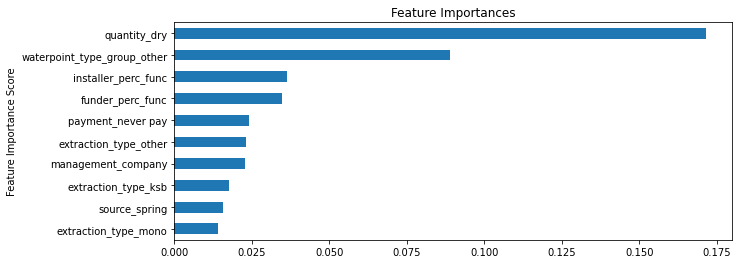

In [315]:
evaluate_clf_model(XGB, X_train_tf, y_train_tf, X_test_tf, y_test_tf);

> XGBoost Evaluation
    - Models are overfit.
    - Relatively high AUC for both train and test datasets.
    - Quantity of water well was the highest affector.
    - High recall for functioning wells and low recall for needing repair wells.
   

## AdaBoost Hypertuning

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
Train Accuracy :  0.7635
Test Accuracy :  0.7644
Train AUC :  0.7425
Test AUC :  0.7374
------------------------------------------------------------

                precision    recall  f1-score   support

   functioning       0.76      0.88      0.81      8490
  needs repair       0.52      0.19      0.28      1019
nonfunctioning       0.79      0.70      0.74      6040

      accuracy                           0.76     15549
     macro avg       0.69      0.59      0.61     15549
  weighted avg       0.76      0.76      0.75     15549

------------------------------------------------------------




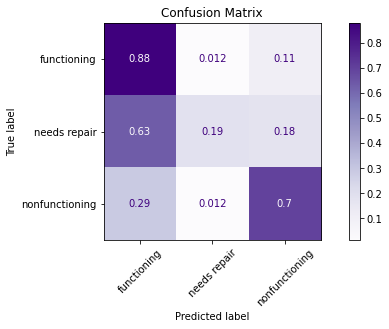

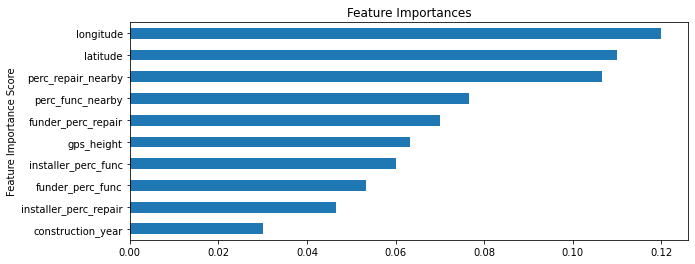

In [316]:
# from sklearn.model_selection import GridSearchCV
AB = AdaBoostClassifier(n_estimators=300)
AB.fit(X_train_tf, y_train_tf)
evaluate_clf_model(AB, X_train_tf, y_train_tf, X_test_tf, y_test_tf);

> Random Forest Evaluation
    - Close train and test sets show us that the model is not over fit.
    - Relatively high AUC for both train and test datasets.
    - various percerntages of functionalities of wells affected the model the most.
    - Relatively balanced recalls for all three categories
   

## Extra Trees

In [317]:
from sklearn.ensemble import ExtraTreesClassifier
ET = ExtraTreesClassifier(n_estimators=200,
                          class_weight=class_weight_dict,
                          max_features=0.7,
                          min_samples_split=0.01)

ET.fit(X_train_tf, y_train_tf)

ExtraTreesClassifier(class_weight={0: 0.6058146719436234, 1: 4.874109901921268,
                                   2: 0.8740001927339308},
                     max_features=0.7, min_samples_split=0.01,
                     n_estimators=200)

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
Train Accuracy :  0.7049
Test Accuracy :  0.6943
Train AUC :  0.8851
Test AUC :  0.8766
------------------------------------------------------------

                precision    recall  f1-score   support

   functioning       0.83      0.69      0.76      8490
  needs repair       0.23      0.77      0.35      1019
nonfunctioning       0.82      0.68      0.75      6040

      accuracy                           0.69     15549
     macro avg       0.63      0.72      0.62     15549
  weighted avg       0.79      0.69      0.73     15549

------------------------------------------------------------




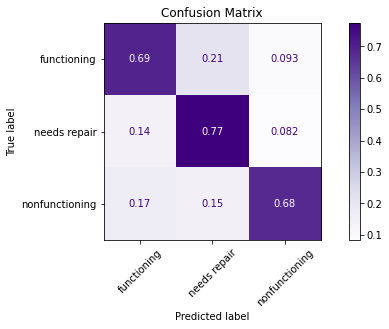

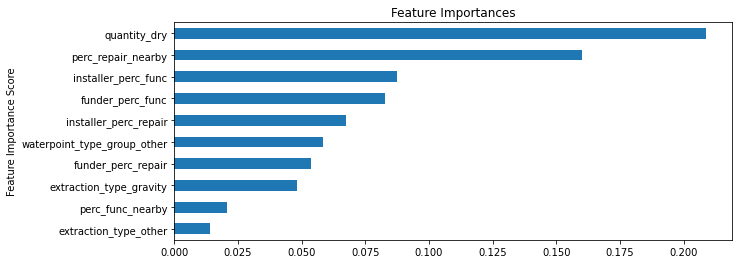

In [318]:
evaluate_clf_model(ET, X_train_tf, y_train_tf, X_test_tf, y_test_tf);

## Gradient Boosting

In [319]:
from sklearn.ensemble import GradientBoostingClassifier
GB = GradientBoostingClassifier(n_estimators=300,
                                max_depth=7,
                                subsample=0.6)
GB.fit(X_train_tf, y_train_tf)

GradientBoostingClassifier(max_depth=7, n_estimators=300, subsample=0.6)

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
Train Accuracy :  0.9348
Test Accuracy :  0.8132
Train AUC :  0.9906
Test AUC :  0.9157
------------------------------------------------------------

                precision    recall  f1-score   support

   functioning       0.81      0.90      0.85      8490
  needs repair       0.53      0.28      0.37      1019
nonfunctioning       0.85      0.78      0.81      6040

      accuracy                           0.81     15549
     macro avg       0.73      0.65      0.68     15549
  weighted avg       0.81      0.81      0.81     15549

------------------------------------------------------------




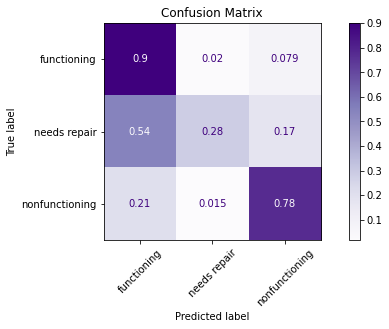

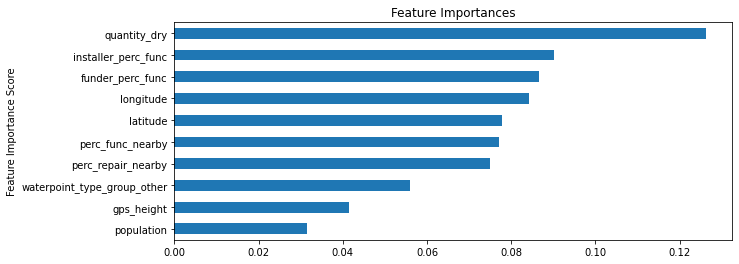

In [320]:
evaluate_clf_model(GB, X_train_tf, y_train_tf, X_test_tf, y_test_tf);

## KNN hypertuning

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
Train Accuracy :  0.8382
Test Accuracy :  0.7768
Train AUC :  0.9477
Test AUC :  0.8697
------------------------------------------------------------

                precision    recall  f1-score   support

   functioning       0.78      0.87      0.82      8490
  needs repair       0.45      0.29      0.35      1019
nonfunctioning       0.81      0.72      0.76      6040

      accuracy                           0.78     15549
     macro avg       0.68      0.63      0.65     15549
  weighted avg       0.77      0.78      0.77     15549

------------------------------------------------------------




AttributeError: 'KNeighborsClassifier' object has no attribute 'feature_importances_'

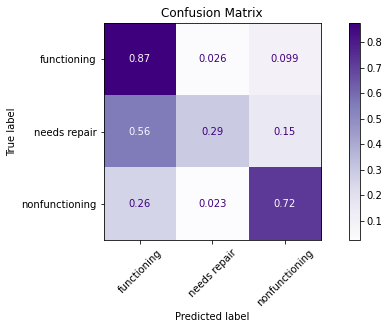

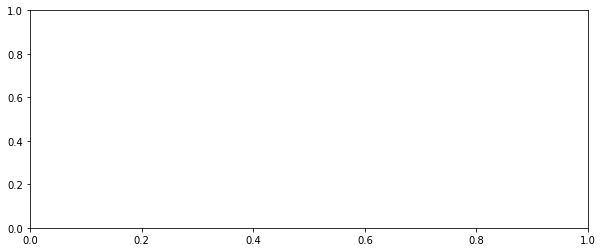

In [321]:
KNN = KNeighborsClassifier()
KNN.fit(X_train_tf, y_train_tf)
evaluate_clf_model(KNN, X_train_tf, y_train_tf, X_test_tf, y_test_tf);

In [ ]:
evaluate_clf_model(grid_sv.best_estimator_, X_train_tf, y_train_tf, X_test_tf, y_test_tf);

# Ensemble

## Visualizing the benefit of ensembling models

In [491]:
# Predictions from different models
y_rf_test = RF.predict(X_test_tf)
y_ab_test = AB.predict(X_test_tf)
y_lr_test = LR.predict(X_test_tf)
y_et_test = ET.predict(X_test_tf)
y_gb_test = GB.predict(X_test_tf)
y_xgb_test = XGB.predict(X_test_tf)
y_knn_test = KNN.predict(X_test_tf)

# Checks whether predicts were correct or not
rf_result = y_rf_test == y_test_tf
ab_result = y_ab_test == y_test_tf
lr_result = y_lr_test == y_test_tf
et_result = y_et_test == y_test_tf
gb_result = y_gb_test == y_test_tf
xgb_result = y_xgb_test == y_test_tf
knn_result = y_knn_test == y_test_tf

In [492]:
# index values for different class
func_ind = pd.Series(y_test_tf)[y_test_tf == 0].index
non_func_ind = pd.Series(y_test_tf)[y_test_tf == 2].index
repair_ind = pd.Series(y_test_tf)[y_test_tf == 1].index

In [493]:
model_results = [rf_result, 
                 ab_result,
                 lr_result,
                 et_result, 
                 gb_result,
                 xgb_result,
                 knn_result]

model_names = ['Random Forest', 
               'AdaBoost',
               'LinearRegressor',
               'Extra Tree', 
               'Gradient Boost',
               'XGBoost',
               'KNN']

In [ ]:
# Compares recall values of different models
def compare_recalls(results, idx, names, label, n=50):
    colors = ['royalblue', 'gold', 'lightseagreen', 'plum', 'firebrick', 'ivory', 'grey']
    fig, ax = plt.subplots(figsize=(14,8))
    
    for k, result in enumerate(results):

        sample = result[idx]
        length = round(len(sample)/n)
        bins = list(range(0,len(sample),length))
        x_val = []
        y_val = []
        for i in range(1,len(bins)):
            x_val.append((bins[i-1] + bins[i])/2)
            y_val.append(round(sum(sample[bins[i-1]: bins[i]])/length, 2))


        sns.barplot(x=x_val, y=y_val, 
                    color=colors[k], 
                    alpha=0.3, 
                    label=names[k], 
                    ax=ax)
#         except:
#             print(names[k])
#             print(result)
#             print(len(idx))
#             break

    plt.legend(loc='lower right', bbox_to_anchor=(1.3, 0.01))
    ax.set(title=f'Recalls for {label} Wells from Different Models', 
           xlabel=f'Index bins (len={length})', 
           ylabel='Recall')
    ax.set_xticklabels([])
    plt.xticks(rotation=45)
    
    return ax


### Functional Wells

(0.6, 1.0)

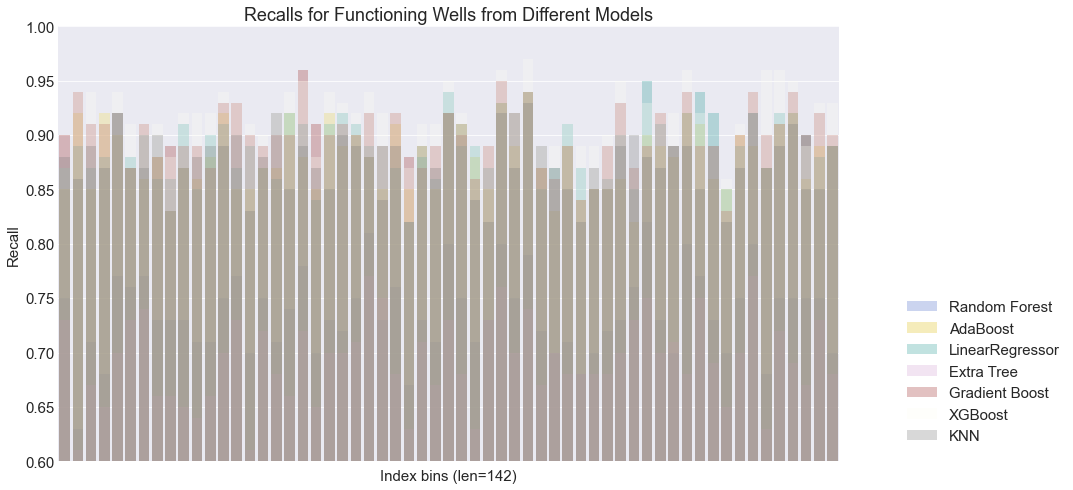

In [761]:
ax = compare_recalls(results=model_results, idx=func_ind, names=model_names, label='Functioning', n=60)
plt.ylim([0.6, 1.0])

### Non Functioning wells

(0.6, 0.9)

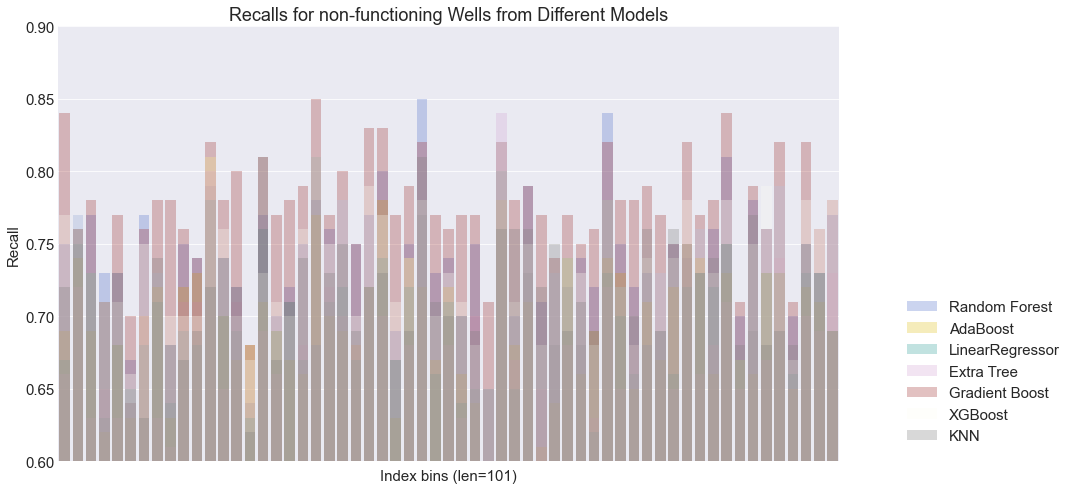

In [764]:
ax = compare_recalls(results=model_results, idx=non_func_ind, names=model_names, label='non-functioning', n=60)
plt.ylim([0.6, 0.9])

### Functional Needs Repair Wells

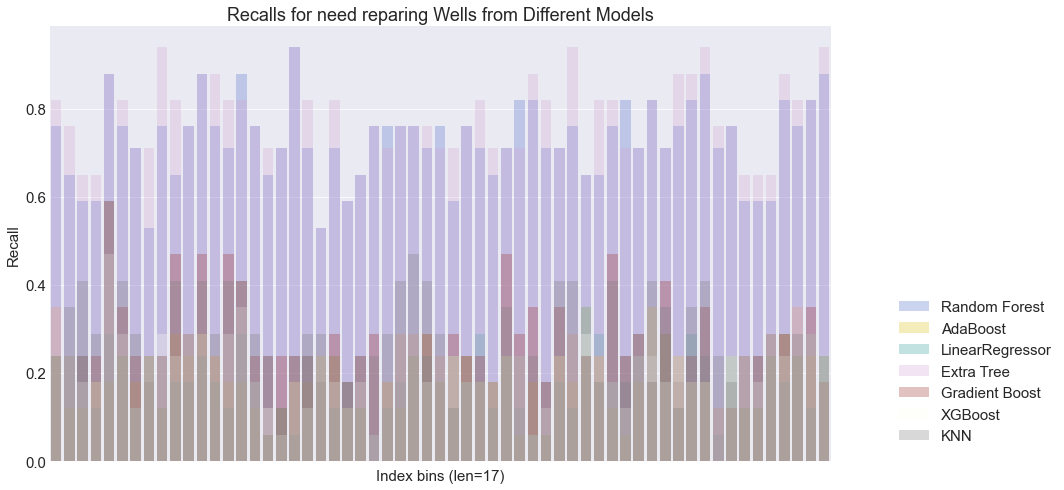

In [762]:
compare_recalls(results=model_results, idx=repair_ind, names=model_names, label='need reparing', n=60)

In [508]:
# Saves models
save_data([RF, LR, AB, ET, GB, XGB, KNN], 'final_models')

## Voting Classifier

In [608]:
from sklearn.metrics import recall_score
recall_score(y_train_tf, RF.predict(X_train_tf), average='macro')

0.8054913227181766

In [610]:
# rf_weight = RF.score(X_train_tf, y_train_tf)
# lr_weight = LR.score(X_train_tf, y_train_tf)
# ab_weight = AB.score(X_train_tf, y_train_tf)
# gb_weight = GB.score(X_train_tf, y_train_tf)
# et_weight = ET.score(X_train_tf, y_train_tf)
# xgb_weight = XGB.score(X_train_tf, y_train_tf)
# knn_weight = KNN.score(X_train_tf, y_train_tf)

# Recall gives weight
rf_weight = recall_score(y_train_tf, RF.predict(X_train_tf), average='macro')
lr_weight = recall_score(y_train_tf, LR.predict(X_train_tf), average='macro')
ab_weight = recall_score(y_train_tf, AB.predict(X_train_tf), average='macro')
gb_weight = recall_score(y_train_tf, GB.predict(X_train_tf), average='macro')
et_weight = recall_score(y_train_tf, ET.predict(X_train_tf), average='macro')
xgb_weight = recall_score(y_train_tf, XGB.predict(X_train_tf), average='macro')
knn_weight = recall_score(y_train_tf, KNN.predict(X_train_tf), average='macro')

### Class weight vote

In [655]:
from sklearn.ensemble import VotingClassifier
estimators = [('rf', RandomForestClassifier(class_weight= class_weight_dict,
                                            criterion='gini',
                                            max_depth=15,
                                            max_features= 'sqrt',
                                            min_samples_split=0.001,
                                            n_estimators= 200)),
#               ('xgb', XGBClassifier(objective='mutli:softmax', num_class=3, 
#                                             class_weight=class_weight_dict,
#                                             n_estimators=200,
#                                             max_depth=5,
#                                             subsample=0.6,
#                                             min_child_weight=0.8)),
#               ('ab', AdaBoostClassifier(learning_rate=1,
#                                         n_estimators=300)),
              ('lr', LogisticRegression(max_iter=1000)),
              ('et', ExtraTreesClassifier(n_estimators=200,
                                          class_weight=class_weight_dict,
                                          max_features=0.7,
                                          min_samples_split=0.01)),
              ('gb', GradientBoostingClassifier(n_estimators=300,
                                                max_depth=7,
                                                subsample=0.6)),]
#               ('knn', KNeighborsClassifier())]

vclf = VotingClassifier(estimators=estimators,
                        voting='soft',
                        weights=[rf_weight, 
                                 lr_weight,
                                 et_weight,
                                 gb_weight])

In [656]:
vclf.fit(X_train_tf, y_train_tf)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight={0: 0.6058146719436234,
                                                                   1: 4.874109901921268,
                                                                   2: 0.8740001927339308},
                                                     max_depth=15,
                                                     max_features='sqrt',
                                                     min_samples_split=0.001,
                                                     n_estimators=200)),
                             ('lr', LogisticRegression(max_iter=1000)),
                             ('et',
                              ExtraTreesClassifier(class_weight={0: 0.6058146719436234,
                                                                 1: 4.874109901921268,
                                                                 2: 0.8740001927339308},
                                                   max_features=0.7,
                                                   min_samples_split=0.01,
                                                   n_estimators=200)),
                             ('gb',
                              GradientBoostingClassifier(max_depth=7,
                                                         n_estimators=300,
                                                         subsample=0.6))],
                 voting='soft',
                 weights=[0.8054913227181766, 0.5871898806175465,
                          0.7440115878875867, 0.8703083495860945])

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
Train Accuracy :  0.8593
Test Accuracy :  0.7995
Train AUC :  0.9552
Test AUC :  0.9074
------------------------------------------------------------

                precision    recall  f1-score   support

   functioning       0.82      0.87      0.84      8490
  needs repair       0.41      0.48      0.44      1019
nonfunctioning       0.85      0.76      0.80      6040

      accuracy                           0.80     15549
     macro avg       0.69      0.70      0.70     15549
  weighted avg       0.81      0.80      0.80     15549

------------------------------------------------------------




AttributeError: 'VotingClassifier' object has no attribute 'feature_importances_'

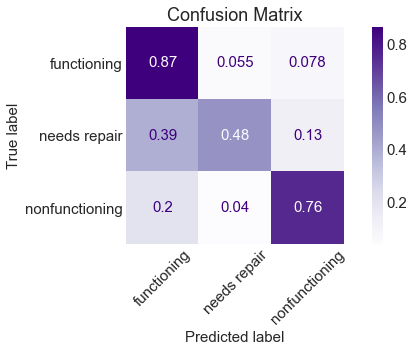

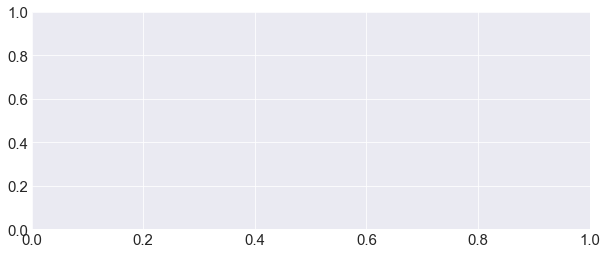

In [657]:
evaluate_clf_model(vclf, X_train_tf, y_train_tf, X_test_tf, y_test_tf)

### Smote_vote

In [658]:
from sklearn.ensemble import VotingClassifier
estimators = [('rf', RandomForestClassifier(criterion='gini',
                                            max_depth=15,
                                            max_features= 'sqrt',
                                            min_samples_split=0.001,
                                            n_estimators= 200)),
#               ('xgb', XGBClassifier(objective='mutli:softmax', num_class=3, 
#                                             n_estimators=200,
#                                             max_depth=5,
#                                             subsample=0.6,
#                                             min_child_weight=0.8)),
#               ('ab', AdaBoostClassifier(learning_rate=1,
#                                         n_estimators=300)),
              ('lr', LogisticRegression(max_iter=1000)),
              ('et', ExtraTreesClassifier(n_estimators=200,
                                          max_features=0.7,
                                          min_samples_split=0.01)),
              ('gb', GradientBoostingClassifier(n_estimators=300,
                                                max_depth=7,
                                                subsample=0.6)),]
#               ('knn', KNeighborsClassifier())]

vclf_smote = VotingClassifier(estimators=estimators,
                        voting='soft',
                        weights=[rf_weight, 
                                 lr_weight,
                                 et_weight,
                                 gb_weight])

In [659]:
vclf_smote.fit(X_train_smote_tf, y_train_smote_tf)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=15,
                                                     max_features='sqrt',
                                                     min_samples_split=0.001,
                                                     n_estimators=200)),
                             ('lr', LogisticRegression(max_iter=1000)),
                             ('et',
                              ExtraTreesClassifier(max_features=0.7,
                                                   min_samples_split=0.01,
                                                   n_estimators=200)),
                             ('gb',
                              GradientBoostingClassifier(max_depth=7,
                                                         n_estimators=300,
                                                         subsample=0.6))],
                 voting='soft',
                 weights=[0.8054913227181766, 0.5871898806175465,
                          0.7440115878875867, 0.8703083495860945])

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
Train Accuracy :  0.819
Test Accuracy :  0.7675
Train AUC :  0.9422
Test AUC :  0.9013
------------------------------------------------------------

                precision    recall  f1-score   support

   functioning       0.84      0.79      0.81      8490
  needs repair       0.31      0.65      0.42      1019
nonfunctioning       0.84      0.75      0.80      6040

      accuracy                           0.77     15549
     macro avg       0.66      0.73      0.68     15549
  weighted avg       0.81      0.77      0.78     15549

------------------------------------------------------------




AttributeError: 'VotingClassifier' object has no attribute 'feature_importances_'

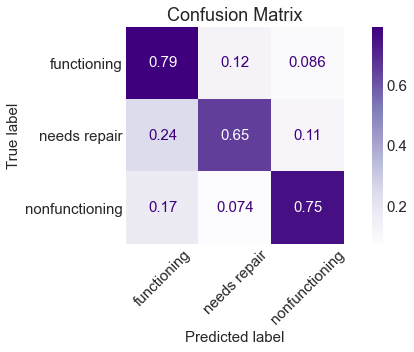

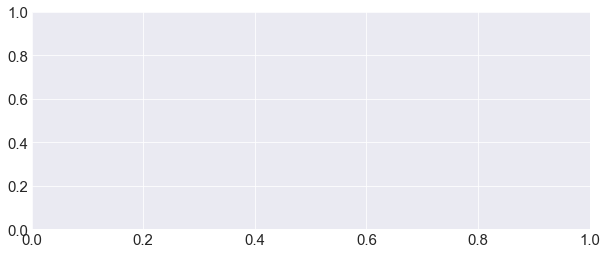

In [660]:
evaluate_clf_model(vclf_smote, X_train_tf, y_train_tf, 
                   X_test_tf, y_test_tf)

## Second Layer

### Organizing Result of the 1st Layer

In [572]:
# Getting predictions of X_train
train = X_train_tf
# Predictions from different models
y_rf_train = RF.predict(train)
y_ab_train = AB.predict(train)
y_lr_train = LR.predict(train)
y_et_train = ET.predict(train)
y_gb_train = GB.predict(train)
y_xgb_train = XGB.predict(train)
y_knn_train = KNN.predict(train)

X_train_predictions = pd.DataFrame({'rf': y_rf_train,
                                    'ab': y_ab_train,
                                    'lr': y_lr_train,
                                    'et': y_et_train,
                                    'gb': y_gb_train,
                                    'xgb': y_xgb_train,
                                    'knn': y_knn_train})

# Getting predictions of X_test
y_rf_test = RF.predict(X_test_tf)
y_ab_test = AB.predict(X_test_tf)
y_lr_test = LR.predict(X_test_tf)
y_et_test = ET.predict(X_test_tf)
y_gb_test = GB.predict(X_test_tf)
y_xgb_test = XGB.predict(X_test_tf)
y_knn_test = KNN.predict(X_test_tf)

X_test_predictions = pd.DataFrame({'rf': y_rf_test,
                                   'ab': y_ab_test,
                                   'lr': y_lr_test,
                                   'et': y_et_test,
                                   'gb': y_gb_test,
                                   'xgb': y_xgb_test,
                                   'knn': y_knn_test})

In [ ]:
# Getting predictions of X_train_smote
train = X_train_smote_tf
# Predictions from different models
y_rf_train_smote = RF.predict(train)
y_ab_train_smote = AB.predict(train)
y_lr_train_smote = LR.predict(train)
y_et_train_smote = ET.predict(train)
y_gb_train_smote = GB.predict(train)
y_xgb_train_smote = XGB.predict(train)
y_knn_train_smote = KNN.predict(train)

X_train_smote_predictions = pd.DataFrame({'rf': y_rf_train,
                                    'ab': y_ab_train,
                                    'lr': y_lr_train,
                                    'et': y_et_train,
                                    'gb': y_gb_train,
                                    'xgb': y_xgb_train,
                                    'knn': y_knn_train})

Text(0.5, 1.0, 'Correlation Map Between the reulsts of different models')

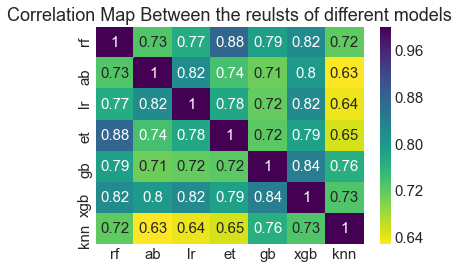

In [573]:
# Corrlation map between different models (Lower the better! - usually)
sns.heatmap(X_test_predictions.corr(), cmap='viridis_r', annot=True)
plt.title('Correlation Map Between the reulsts of different models')

In [574]:
features_included = ['rf', 'lr', 'gb', 'knn', 'ab', 'xgb', 'et']

### Best Recall

In [ ]:
features_included = ['rf',  'gb', 'knn', 'lr', 'ab' ]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF_2 = RandomForestClassifier(n_estimators= 500,
                              max_depth= 5,
                              min_samples_split=0.005,
                              max_features=0.2,
                              class_weight=class_weight_dict)
RF_2.fit(X_train_predictions[features_included], y_train_tf)
# predictions = gbm.predict(x_test)

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
Train Accuracy :  0.8479
Test Accuracy :  0.762
Train AUC :  0.9384
Test AUC :  0.8729
------------------------------------------------------------

                precision    recall  f1-score   support

   functioning       0.85      0.77      0.80      8490
  needs repair       0.28      0.67      0.40      1019
nonfunctioning       0.86      0.77      0.81      6040

      accuracy                           0.76     15549
     macro avg       0.66      0.74      0.67     15549
  weighted avg       0.81      0.76      0.78     15549

------------------------------------------------------------




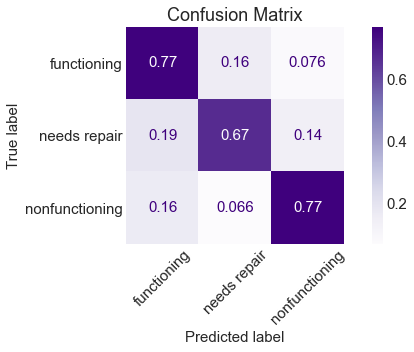

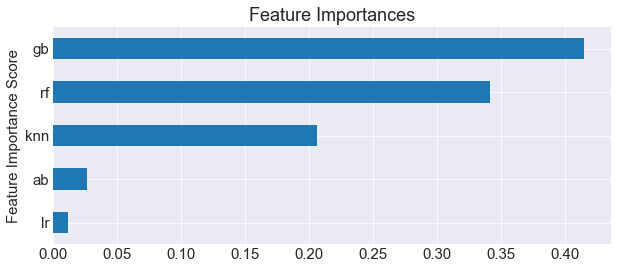

In [569]:
evaluate_clf_model(RF_2, X_train_predictions[features_included], y_train_smote_tf, 
                   X_test_predictions[features_included], y_test_tf, 
                   features=features_included);

### Best Accuracy

In [588]:
features_included = ['rf',  'gb', 'knn', 'et', 'xgb', 'ab', 'lr']

In [597]:
from sklearn.ensemble import AdaBoostClassifier
final_ab = AdaBoostClassifier(n_estimators=500)
final_ab.fit(X_train_predictions[features_included], y_train_tf)
# predictions = gbm.predict(x_test)

AdaBoostClassifier(n_estimators=500)

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
Train Accuracy :  0.9348
Test Accuracy :  0.8132
Train AUC :  0.9497
Test AUC :  0.8471
------------------------------------------------------------

                precision    recall  f1-score   support

   functioning       0.81      0.90      0.85      8490
  needs repair       0.53      0.28      0.37      1019
nonfunctioning       0.85      0.78      0.81      6040

      accuracy                           0.81     15549
     macro avg       0.73      0.65      0.68     15549
  weighted avg       0.81      0.81      0.81     15549

------------------------------------------------------------




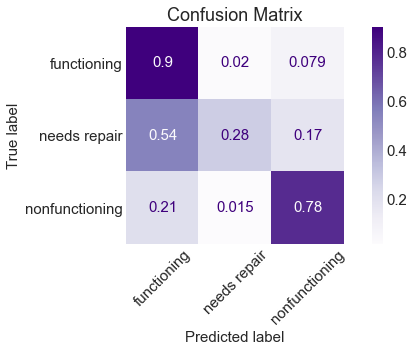

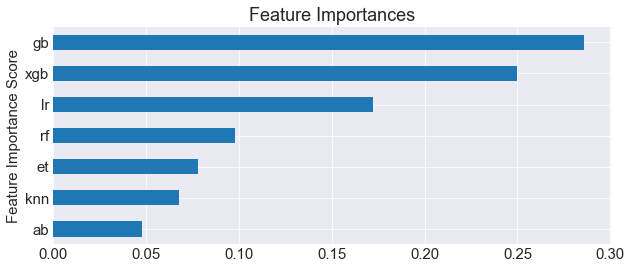

In [598]:
evaluate_clf_model(final_ab, X_train_predictions[features_included], y_train_tf, X_test_predictions[features_included], y_test_tf, 
                   features=features_included);

## Creating Correlation Map

In [687]:
status = {0:'functional', 1:'repair', 2:'non functional'}
y = pd.DataFrame(y_train_tf, columns=['status_group'])
y['status_group']=y['status_group'].apply(lambda x: status[x])
y = pd.get_dummies(y)
y.columns=['functional', 'non functional', 'repair']
df_test = pd.concat([X_train_tf, y], axis=1)

In [690]:
df_test

,gps_height,longitude,latitude,region_code,district_code,population,construction_year,year_recorded,month_recorded,perc_func_nearby,...,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other,wpt_name_False,wpt_name_True,functional,non functional,repair
0,1.435816,-0.256214,-1.376048,-0.230433,-0.088365,-0.151195,-0.782983,-0.900086,-0.436093,1.761198,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0
1,1.800097,-1.316811,-0.795271,-0.010513,-0.188039,0.711401,-1.434149,1.184856,-1.113344,-0.693659,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0
2,0.960667,-0.388206,1.085076,0.099447,-0.487060,0.711401,-0.050422,1.184856,-0.774718,0.424658,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,1
3,0.543112,0.752072,0.947126,-0.670274,-0.088365,-0.364043,-0.213213,1.184856,0.579783,1.177255,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0
4,-0.980243,-0.998025,-1.145203,-0.175453,0.011309,-0.408853,0.763535,-0.900086,0.918409,-0.823021,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36273,1.412779,-0.009618,0.605066,0.319367,-0.287712,-0.012283,0.600744,1.184856,-0.774718,0.648926,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0
36274,-1.007600,1.509658,-0.578026,-0.505334,-0.188039,-0.283385,0.519348,-0.900086,-0.436093,-1.345305,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,0
36275,-0.980243,-0.636469,0.895632,0.099447,0.210656,-0.408853,0.844931,0.142385,1.934285,0.107298,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,0
36276,1.479012,0.242324,-0.722373,-0.230433,0.110982,0.487350,0.519348,-0.900086,-0.774718,0.766803,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1,0


In [715]:
df_corr = df_test.corr()

In [716]:
df_corr.drop(labels=['functional', 
                      'non functional',
                      'repair', 'payment_pay annually', 
                     'payment_pay per bucket', 
                     'payment_pay monthly',
                     'payment_never pay'], axis=0, inplace=True)

In [721]:
df_corr = df_corr[['functional', 'non functional', 'repair']]
top10_func = df_corr.sort_values(by='functional', ascending=False).head(10)


In [722]:
bottom10_func = df_corr.sort_values(by='functional', ascending=False).tail(11)

In [726]:
df_func = pd.concat([top10_func, bottom10_func], sort=True, axis=0)
df_func

,functional,non functional,repair
installer_perc_func,0.425822,-0.397615,-0.074093
funder_perc_func,0.403439,-0.370702,-0.081769
perc_func_nearby,0.349886,-0.316398,-0.080721
quantity_enough,0.254304,-0.260380,-0.000139
construction_year,0.150061,-0.142289,-0.021937
gps_height,0.137775,-0.140898,-0.000400
payment_type_annually,0.111398,-0.113328,-0.001470
wpt_name_False,0.108326,-0.082421,-0.054890
extraction_type_gravity,0.107308,-0.171690,0.118900
payment_type_per bucket,0.099846,-0.085055,-0.033108


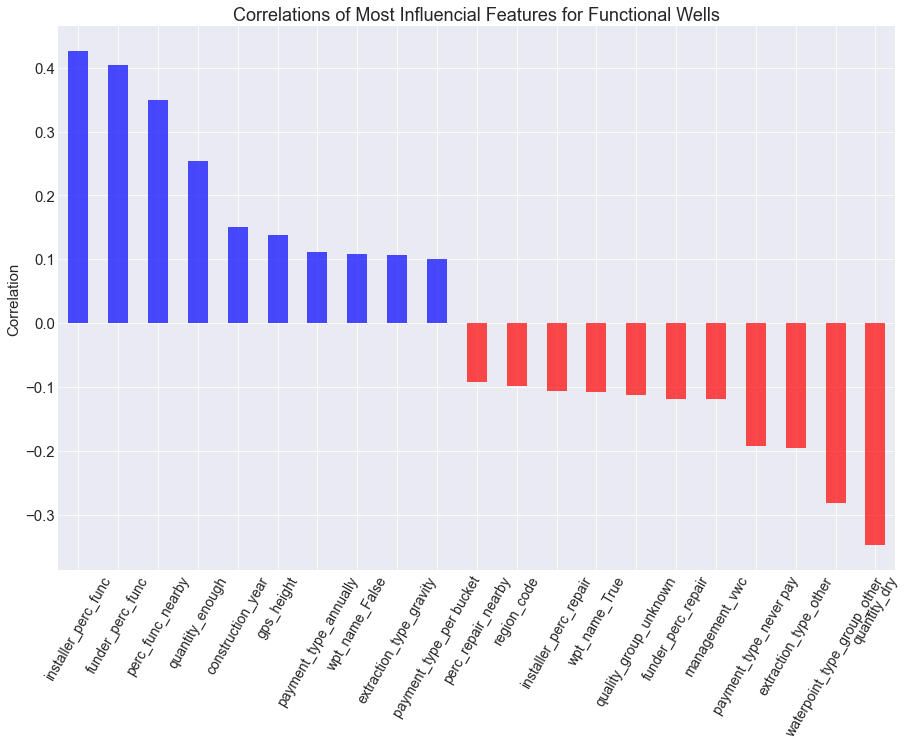

In [753]:
fig, ax = plt.subplots(figsize=(15,10))
color_choices = ['b']*np.sum(df_func['functional']>0) + ['r']*np.sum(df_func['functional']<0)
df_func['functional'].plot(kind='bar', ax=ax, color=color_choices, alpha=0.7)
ax.set(ylabel='Correlation', title='Correlations of Most Influencial Features for Functional Wells')
plt.xticks(rotation=60, fontsize=14);

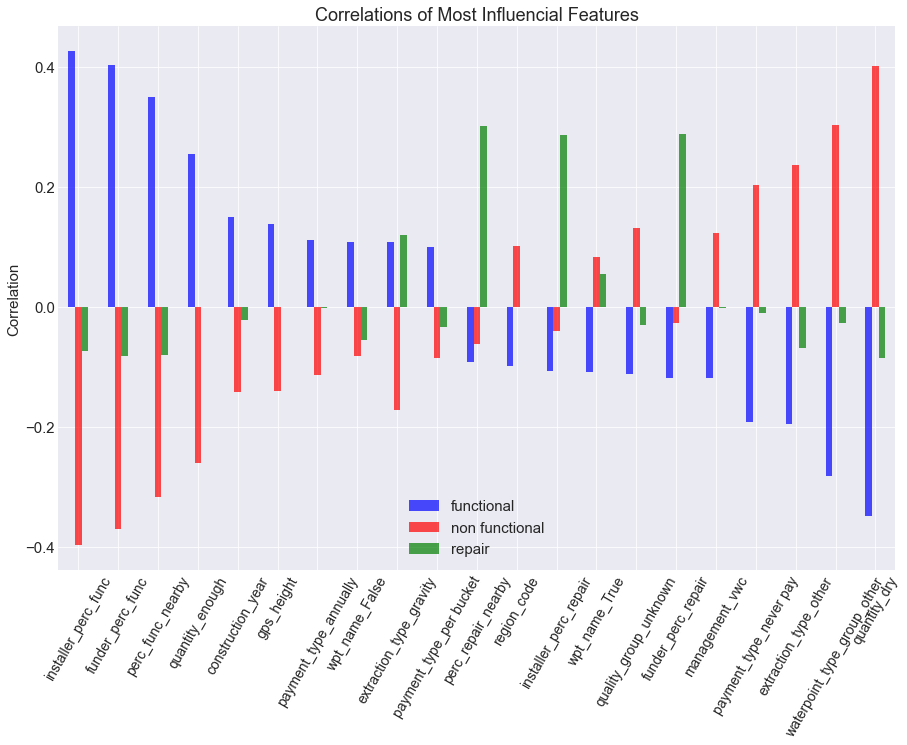

In [758]:
fig, ax = plt.subplots(figsize=(15,10))
# color_choices = ['b']*np.sum(df_func['functional']>0) + ['r']*np.sum(df_func['functional']<0)
df_func.plot(kind='bar', ax=ax, color=['b', 'r', 'g'], alpha=0.7)
ax.set(ylabel='Correlation', title='Correlations of Most Influencial Features')
plt.xticks(rotation=60, fontsize=14);

In [746]:
np.sum(df_func['functional']>0)bb

10

# Final Test

In [171]:
def import_test_data(drop_cols=None):
    X = pd.read_csv('datasets/Tanzanian/test_set.csv')
    
    X['date_recorded'] = pd.to_datetime(X['date_recorded'])
    X['year_recorded'] = X['date_recorded'].apply(lambda x: x.year)
    X['month_recorded'] = X['date_recorded'].apply(lambda x: x.month)
    X.drop(columns=['date_recorded'], axis=1, inplace=True)
    
    # 1 if a name exists and 0 if not.
    X['wpt_name'] = X['wpt_name']!='none'
    
    if drop_cols != None:
        X.drop(columns=drop_cols, axis=1, inplace=True)

    impute = SimpleImputer(strategy='most_frequent')
    X['permit'].fillna(True, inplace=True)
    X['public_meeting'].fillna(True, inplace=True)
    
    Xt=impute.fit_transform(X)
    Xt = pd.DataFrame(Xt, columns=X.columns)
    return Xt

## Importing and processing Test Data

In [176]:
Xt = import_test_data(cols_to_drop)

In [177]:
Xt

,funder,gps_height,installer,longitude,latitude,wpt_name,region_code,district_code,population,public_meeting,...,management_group,payment,payment_type,quality_group,quantity,source,source_class,waterpoint_type_group,year_recorded,month_recorded
0,Dmdd,1996,DMDD,35.2908,-4.0597,True,21,3,321,True,...,parastatal,never pay,never pay,good,seasonal,rainwater harvesting,surface,other,2013,2
1,Government Of Tanzania,1569,DWE,36.6567,-3.30921,True,2,2,300,True,...,user-group,never pay,never pay,good,insufficient,spring,groundwater,communal standpipe,2013,2
2,Government Of Tanzania,1567,DWE,34.7679,-5.00434,True,13,2,500,True,...,user-group,never pay,never pay,good,insufficient,rainwater harvesting,surface,other,2013,2
3,Finn Water,267,FINN WATER,38.058,-9.41867,True,80,43,250,True,...,user-group,unknown,unknown,good,dry,shallow well,groundwater,other,2013,1
4,Bruder,1260,BRUDER,35.0061,-10.9504,True,10,3,60,True,...,user-group,pay monthly,monthly,good,enough,spring,groundwater,communal standpipe,2013,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,Danida,34,Da,38.8527,-6.58284,True,6,1,20,True,...,user-group,never pay,never pay,good,enough,river,surface,communal standpipe,2011,2
14846,Hiap,0,HIAP,37.4516,-5.35043,True,4,7,2960,True,...,user-group,pay annually,annually,salty,insufficient,shallow well,groundwater,hand pump,2011,3
14847,Government Of Tanzania,1476,DWE,34.7398,-4.58559,True,13,2,200,True,...,user-group,never pay,never pay,good,insufficient,dam,surface,communal standpipe,2013,3
14848,Germany,998,DWE,35.4327,-10.5842,True,10,2,150,True,...,user-group,never pay,never pay,good,insufficient,river,surface,communal standpipe,2013,2


## Cleaning up
### Distance Percentages

In [184]:
# Calculates percentage of functional, nonfunctional, and need repair wells within certain radius (30 km)
perc_func_near = []
perc_non_func_near = []
perc_repair_near = []

for index, row in Xt.iterrows():
#     print(index, row['latitude'], row['longitude'])
    wp = [row['latitude'], row['longitude']]
    wps = df[['latitude', 'longitude']].copy()
    
    d = get_distance(wp, wps)
    
    distance = 30
    indices = df[d < distance].index
    

    perc_func = round(np.sum(y.iloc[indices] == 'functional')/len(indices)*100, 2)
    perc_non_func = round(np.sum(y.iloc[indices] == 'non functional')/len(indices)*100, 2)
    perc_repair_func = round(np.sum(y.iloc[indices] == 'functional needs repair')/len(indices)*100, 2)
    
    perc_func_near.append(perc_func)
    perc_non_func_near.append(perc_non_func)
    perc_repair_near.append(perc_repair_func)

# Assigns percentages in appropriate columns
Xt['perc_func_nearby'] = perc_func_near
Xt['perc_on_func_nearby'] = perc_non_func_near
Xt['perc_repair_nearby'] = perc_repair_near

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


### Extraction

In [186]:
# Extraction dictionary to simplify some of trivial ones as 'other'
extraction_dict = {'nira/tanira':'nira', 'swn 80':'other', 
                   'other - rope pump': 'other', 'other - swn 81': 'other',
                   'other - play pump': 'other', 'other - mkulima/shinyanga':'other',
                   'windmill': 'other', 'cemo':'other', 'climax':'other',
                   'walimi':'other', 'india mark iii':'other'}

# replaces insignificant extractor types as 'other'
Xt['extraction_type'] = Xt['extraction_type'].apply(lambda x: extraction_dict[x] if x in extraction_dict.keys() else x)

### Installer and funder

In [187]:
installer_dict = load_data('installer_dict')
funder_dict = load_data('funder_dict')

In [188]:
def perc(data, col, perc_dict):
    data[f'{col}_perc_func'] = data[col].apply(lambda x: perc_dict[x][0] if x in perc_dict.keys() else np.NaN)
    data[f'{col}_perc_repair'] = data[col].apply(lambda x: perc_dict[x][1] if x in perc_dict.keys() else np.NaN)
    data[f'{col}_perc_non_func'] = data[col].apply(lambda x: perc_dict[x][2] if x in perc_dict.keys() else np.NaN)
    
    data.drop(columns=col, axis=1, inplace=True)

In [189]:
perc(Xt, 'installer', installer_dict)
perc(Xt, 'funder', funder_dict)

In [190]:
mean_lat = Xt['latitude'].mean()
mean_long = Xt['longitude'].mean()
print(mean_lat, mean_long)

-5.684724494104389 34.061605211379835


In [191]:
Xt['latitude'] = Xt['latitude'].apply(lambda x: mean_lat if x >-0.1 else x)

In [192]:
Xt['longitude'] = Xt['longitude'].apply(lambda x: mean_long if x <1 else x)

In [194]:
Xt_tf = preprocessing2.transform(Xt)
feature_names = preprocessing2.named_transformers_['cat'].\
                named_steps['encoder'].get_feature_names(cat_cols).tolist()
feature_names

features = num_cols + feature_names

Xt_tf = pd.DataFrame(Xt_tf, columns = features)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


## 1 layer

In [217]:
# Getting predictions of X_train
train = Xt_tf
y_rf_train = RF.predict(train)
y_ab_train = AB.predict(train)
y_lr_train = LR.predict(train)
y_et_train = ET.predict(train)
y_gb_train = GB.predict(train)


Xt_predictions = pd.DataFrame({'rf': y_rf_train,
                                    'ab': y_ab_train,
                                    'lr': y_lr_train,
                                    'et': y_et_train,
                                    'gb': y_gb_train})


## 2nd layer

In [218]:
final_pred_LR_2 = LR_2.predict(Xt_predictions[features_included])
final_pred_LR_2

array([2, 0, 2, ..., 0, 0, 2])

In [ ]:
final_pred_acc = rf.predict(Xt_predictions[features_included])
final_pred_acc

In [ ]:
final_pred_acc2 = final_ab.predict(Xt_predictions[features_included])
final_pred_acc2

## Voting model

In [514]:
final_pred_voting = vclf.predict(Xt_tf)

## Making submission file

In [219]:
final = pd.read_csv('datasets/Tanzanian/SubmissionFormat.csv')

In [220]:
def make_final(final, final_pred):
    final['status_group'] = final_pred
    status_group_dict = {0:'functional', 1:'functional needs repair', 2:'non functional'}
    final['status_group']=final['status_group'].apply(lambda x: status_group_dict[x])
    return final

In [515]:
final = make_final(final, final_pred_voting)
final['status_group'].value_counts(normalize=True)

functional                 0.626128
non functional             0.335623
functional needs repair    0.038249
Name: status_group, dtype: float64

In [221]:
final = make_final(final, final_pred_LR_2)
final['status_group'].value_counts(normalize=True)

functional                 0.612727
non functional             0.373199
functional needs repair    0.014074
Name: status_group, dtype: float64

In [516]:
final.to_csv(r'final_submission_voting2.csv', index = False)

> Model 1: Accuracy = 0.7006
Model 2: Accuracy = 0.7863


# Appendix

In [453]:
X = pd.read_csv('datasets/Tanzanian/training_set.csv')
y = pd.read_csv('datasets/Tanzanian/train_result.csv')
df = pd.concat([X, y], axis=1)

## Using plotly express

In [350]:
with open('datasets/Tanzanian/TZ_state_1.geojson', 'r') as f:
    tz_states = json.load(f)

In [351]:
state_id_map = {}
for feature in tz_states['features']:
    feature['id'] = feature['properties']['ID_1']
    state_id_map[feature['properties']['NAME_1']] = feature['id']
state_id_map['Dar es Salaam'] = 2
state_id_map.pop('Dar-Es-Salaam')

2

In [353]:
df['region_id'] = df['region'].apply(lambda x: state_id_map[x])

In [354]:
df.keys()

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'id', 'status_group', 'region_id'],
      dtype='object')

In [358]:
df_region = pd.DataFrame(dict(id=list(state_id_map.values()),region = list(state_id_map.keys())))
df_region

,id,region
0,1,Arusha
1,3,Dodoma
2,4,Iringa
3,5,Kagera
4,6,Kaskazini-Pemba
5,7,Kaskazini-Unguja
6,8,Kigoma
7,9,Kilimanjaro
8,10,Kusini-Pemba
9,11,Lindi


In [359]:
total_nums = []
total_func = []
total_repair = []
total_non_func = []

main_source = []
main_source_perc = []

quantity = []
quantity_perc = []

for region in df_region['region']:
    df_copy = df[df['region']==region].copy()
    if df_copy.shape[0] != 0:
        total_num = df_copy.shape[0]
        # Total number of wells installed in the region
        total_nums.append(total_num)

        # Total number of wells that are functions, non functional, and needs repair
        total_func.append((df_copy['status_group'] == 'functional').sum())
        total_non_func.append((df_copy['status_group'] == 'non functional').sum())
        total_repair.append((df_copy['status_group'] == 'functional needs repair').sum())

        # main water source
        try:
            main_source.append(df_copy['source_class'].value_counts(normalize=True).index[0])
            main_source_perc.append(df_copy['source_class'].value_counts(normalize=True)[0])
        except:
            print(region)

        # water quantity
        quantity.append(df_copy['quantity'].value_counts(normalize=True).index[0])
        quantity_perc.append(df_copy['quantity'].value_counts(normalize=True)[0])
    else:
        total_nums.append(0)
        total_func.append(0)
        total_non_func.append(0)
        total_repair.append(0)
        
        main_source.append(0)
        main_source_perc.append(0)
        
        quantity.append(0)
        quantity_perc.append(0)

        

In [360]:
df_region['total_nums'] = total_nums
df_region['total_func'] = total_func
df_region['total_repair'] = total_repair
df_region['total_non_func'] = total_non_func

df_region['main_source'] = main_source
df_region['main_source_perc'] = main_source_perc

df_region['quantity'] = quantity
df_region['quantity_perc'] = quantity_perc

In [361]:
df_region['func_perc']=round(df_region['total_func']/df_region['total_nums']*100,2)
df_region['non_func_perc']=round(df_region['total_non_func']/df_region['total_nums']*100,2)
df_region['repair_perc']=round(df_region['total_repair']/df_region['total_nums']*100,2)


In [362]:
df_region.dropna()

,id,region,total_nums,total_func,total_repair,total_non_func,main_source,main_source_perc,quantity,quantity_perc,func_perc,non_func_perc,repair_perc
0,1,Arusha,3350,2294,175,881,groundwater,0.683582,insufficient,0.522687,68.48,26.30,5.22
1,3,Dodoma,2201,1009,209,983,groundwater,0.962744,enough,0.484780,45.84,44.66,9.50
2,4,Iringa,5294,4141,123,1030,groundwater,0.773706,enough,0.824518,78.22,19.46,2.32
3,5,Kagera,3316,1727,304,1285,groundwater,0.842280,enough,0.581122,52.08,38.75,9.17
6,8,Kigoma,2816,1363,603,850,surface,0.512074,enough,0.670099,48.40,30.18,21.41
7,9,Kilimanjaro,4379,2640,322,1417,groundwater,0.870290,enough,0.590089,60.29,32.36,7.35
9,11,Lindi,1546,460,93,993,groundwater,0.855757,enough,0.495472,29.75,64.23,6.02
10,12,Manyara,1583,987,96,500,groundwater,0.772584,enough,0.620973,62.35,31.59,6.06
11,13,Mara,1969,886,60,1023,groundwater,0.689690,enough,0.657694,45.00,51.96,3.05
12,14,Mbeya,4639,2319,504,1816,groundwater,0.680966,enough,0.483078,49.99,39.15,10.86


In [370]:
from ipywidgets import interact

In [383]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook'

In [618]:
# Shows a plotly express graph with feature of your choice!
@interact(color=df_region.keys())
def plot_choropleth(color):
    fig = px.choropleth(df_region, locations='id', 
                  geojson=tz_states, 
                  hover_name = 'region',
                  hover_data = ['func_perc', 'non_func_perc', 'repair_perc', 'total_nums'],
                  scope='africa',
                  color=color,
                  width = 800,
                  height= 800)
    fig.show()

## Cumulative Number of Wells 

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



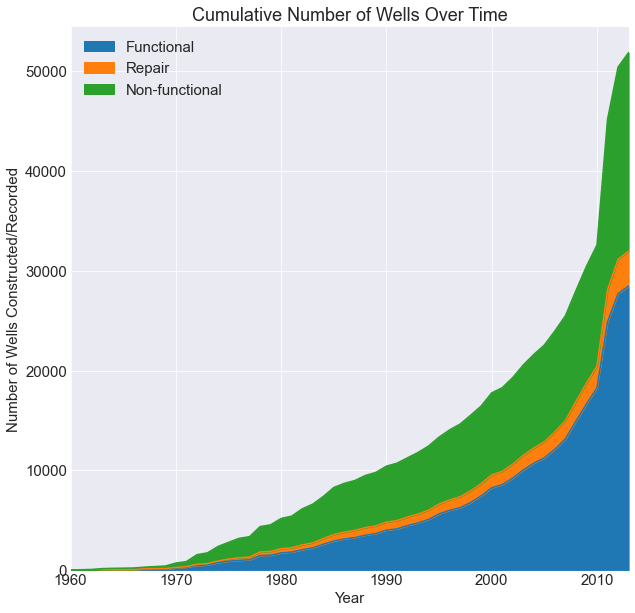

In [395]:
df = load_data('final_df')
df = pd.concat([df, pd.get_dummies(df['status_group'])], axis=1)
# Changes 0 to recorded year for construction year
mask = df['construction_year'] == 0
df['construction_year'][mask] = df['year_recorded'][mask]

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 15})
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(10,10))
cum_sum = pd.DataFrame({'Functional': df.groupby('construction_year').sum()['functional'].cumsum(),
                        'Repair': df.groupby('construction_year').sum()['functional needs repair'].cumsum(),
                        'Non-functional': df.groupby('construction_year').sum()['non functional'].cumsum()},
                       index=df.groupby('construction_year').sum().index)

cum_sum.plot.area(ax=ax)

# ax = df.groupby('construction_year').count()['status_group'].cumsum().plot(figsize=(10,10))
# df.groupby('construction_year').sum()['functional'].cumsum().plot(figsize=(10,10), c='r', label='Functional Wells')
ax.set(xlabel="Year", ylabel="Number of Wells Constructed/Recorded", title='Cumulative Number of Wells Over Time');
plt.legend()


In [397]:
df.keys()

Index(['gps_height', 'longitude', 'latitude', 'wpt_name', 'region_code',
       'district_code', 'population', 'public_meeting', 'scheme_management',
       'permit', 'construction_year', 'extraction_type', 'management',
       'management_group', 'payment', 'payment_type', 'quality_group',
       'quantity', 'source', 'source_class', 'waterpoint_type_group',
       'year_recorded', 'month_recorded', 'status_group', 'perc_func_nearby',
       'perc_on_func_nearby', 'perc_repair_nearby', 'installer_perc_func',
       'installer_perc_repair', 'installer_perc_non_func', 'funder_perc_func',
       'funder_perc_repair', 'funder_perc_non_func', 'functional',
       'functional needs repair', 'non functional'],
      dtype='object')

## Functionality by quantity

In [446]:
df2 = df.groupby('quantity').sum()[['functional', 'functional needs repair', 'non functional']]

df2_sums = df2.sum(axis=1)

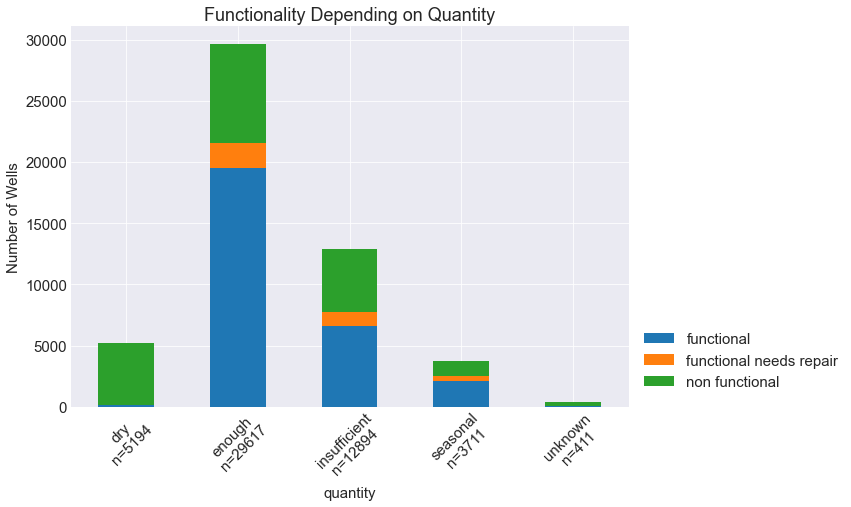

In [447]:
fig, ax = plt.subplots(figsize=(10,7))
df2.plot(kind='bar', stacked=True, ax=ax)
ax.set(ylabel='Number of Wells', title='Functionality Depending on Quantity')
# ax.set_xticklabels(years, rotation=65)
ax.set_xticklabels([x + f'\nn={int(df2_sums[i])}' for i, x in enumerate(['dry', 'enough', 'insufficient', 'seasonal', 'unknown'])], rotation=45)
plt.legend(loc='lower right', bbox_to_anchor=(1.4, 0.01))

In [443]:
# normalizes the data
for i, col in enumerate(df2.columns):
    df2[col] = df2[col] / df2_sums
df2

,functional,functional needs repair,non functional
quantity,,,
dry,0.025992,0.003080,0.970928
enough,0.658507,0.068103,0.273390
insufficient,0.512719,0.085156,0.402125
seasonal,0.572083,0.098626,0.329291
unknown,0.192214,0.007299,0.800487


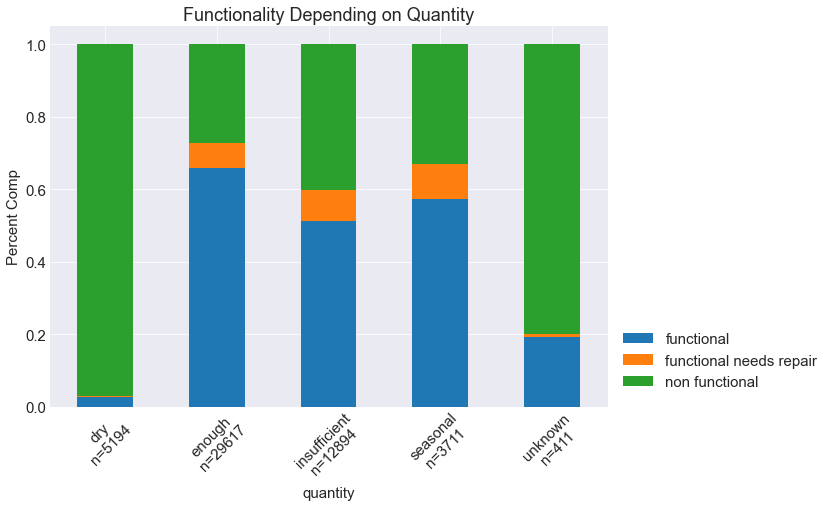

In [444]:
fig, ax = plt.subplots(figsize=(10,7))
df2.plot(kind='bar', stacked=True, ax=ax)
ax.set(ylabel='Percent Comp', title='Functionality Depending on Quantity')
# ax.set_xticklabels(years, rotation=65)
ax.set_xticklabels([x + f'\nn={int(df2_sums[i])}' for i, x in enumerate(['dry', 'enough', 'insufficient', 'seasonal', 'unknown'])], rotation=45)
plt.legend(loc='lower right', bbox_to_anchor=(1.4, 0.01))


## Functionality depending on Funder

In [454]:
# Reset data
X = pd.read_csv('datasets/Tanzanian/training_set.csv')
y = pd.read_csv('datasets/Tanzanian/train_result.csv')
df = pd.concat([X, y], axis=1)
df = pd.concat([df, pd.get_dummies(df['status_group'])], axis=1)

In [485]:
df2 = df.groupby('funder').sum()[['functional', 'functional needs repair', 'non functional']]
df2['total'] = df2_sums
df2_sums = df2.sum(axis=1)
df2 = df2.sort_values(by='total', ascending=False)
df2.drop(columns='total').iloc[:10,:]

,functional,functional needs repair,non functional
funder,,,
Government Of Tanzania,3720.0,701.0,4663.0
Danida,1713.0,159.0,1242.0
Hesawa,936.0,232.0,1034.0
Rwssp,805.0,109.0,460.0
World Bank,545.0,97.0,707.0
Kkkt,723.0,66.0,498.0
World Vision,743.0,131.0,372.0
Unicef,600.0,99.0,358.0
Tasaf,493.0,64.0,320.0


[Text(0, 0, 'Government Of Tanzania'),
 Text(1, 0, 'Danida'),
 Text(2, 0, 'Hesawa'),
 Text(3, 0, 'Rwssp'),
 Text(4, 0, 'World Bank'),
 Text(5, 0, 'Kkkt'),
 Text(6, 0, 'World Vision'),
 Text(7, 0, 'Unicef'),
 Text(8, 0, 'Tasaf'),
 Text(9, 0, 'District Council'),
 Text(10, 0, 'Dhv'),
 Text(11, 0, 'Private Individual'),
 Text(12, 0, 'Dwsp'),
 Text(13, 0, '0'),
 Text(14, 0, 'Norad')]

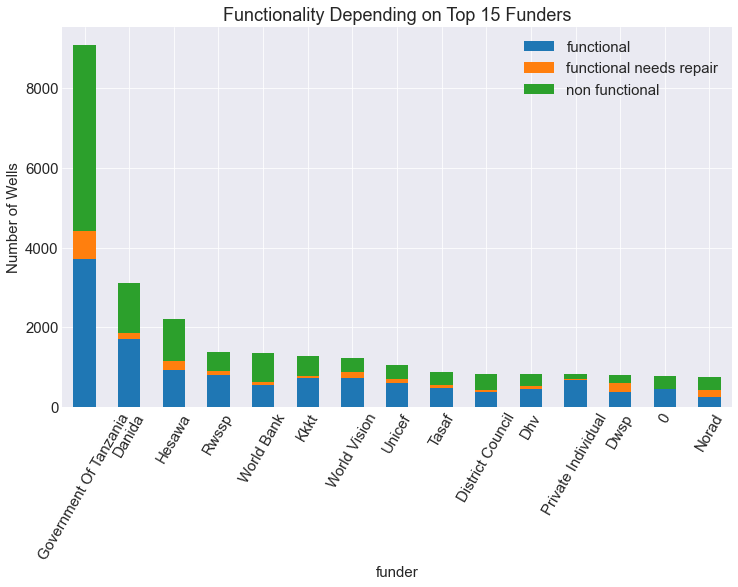

In [489]:
fig, ax = plt.subplots(figsize=(12,7))
df2.drop(columns='total').iloc[:15,:].plot(kind='bar', stacked=True, ax=ax)
ax.set(ylabel='Number of Wells', title='Functionality Depending on Top 15 Funders')
ax.set_xticklabels(df2.index[:15], rotation=60);
# plt.legend(loc='lower right', bbox_to_anchor=(1.4, 0.01))

In [464]:
# Normalizes the data
for i, col in enumerate(df2.columns):
    df2[col] = df2[col] / df2_sums
df2

,functional,functional needs repair,non functional
funder,,,
0,0.572716,0.003861,0.423423
A/co Germany,0.466667,0.066667,0.466667
Aar,0.666667,0.121212,0.212121
Abas Ka,1.000000,0.000000,0.000000
Abasia,0.837209,0.046512,0.116279
...,...,...,...
Zao,0.000000,0.000000,1.000000
Zao Water Spring,1.000000,0.000000,0.000000
Zao Water Spring X,0.000000,0.000000,1.000000
